# 0 Imports


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import pickle
from collections import Counter

from IPython.core.display import display, HTML
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import cross_validate

from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

from imblearn.over_sampling  import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import NearMiss, TomekLinks, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt import gp_minimize, dump

from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score
from scikitplot.metrics import plot_ks_statistic
from skopt.plots import plot_convergence
from sklearn.metrics import roc_auc_score, classification_report


## 0.2 Helper Functions

In [2]:
# Defining some plot settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

# function that evaluates RepeatedStratifiedKFold for a pipeline
def eval_model_cv( pipe, X_train_t, y_train, method:str, n_spt:int, n_rep:int ):
    
    # define cross val
    cv = RepeatedStratifiedKFold(n_splits = n_spt, n_repeats= n_rep, random_state = 42)
    
    # calculate scores for crossvalidated pipeline
    scores = cross_val_score( pipe, X_train_t, y_train, scoring='roc_auc', cv = cv, n_jobs= -1 )
    
    # model name from pipeline
    model = list(pipe.named_steps.keys())[-1]

    # result dataframe and append model name and method to each result
    res = {'roc_auc': scores,
    'model':  [model]*n_spt*n_rep,
    'method': [method]*n_spt*n_rep }
    
    # create result df
    df = pd.DataFrame(res)
    print( 'Method: {:<25} ROC_AUC: {}'.format( method ,np.mean(scores)))
    return df


# evals metrics especified in sccoring dict with RepeatedStratifiedKFold and returns a dataframe with results
def eval_models( models:list, scoring:dict, n_splits:int, n_repeats:int, verbose=0):
    # results data frame
    results = pd.DataFrame()
    
    #define cross validation
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats= n_repeats, random_state = 42)
    
    for model in models:
    
        #define pipeline
        pipe = imbPipeline( steps =[ ('ncr', ncr), ('model', model) ] )

        # calculate scores for crossvalidated pipeline
        scores = cross_validate( pipe, X_train_t, y_train, cv = cv, scoring = scoring, verbose = verbose, n_jobs = -1) 
        
        # get model name from pipeline
        #model_name = str(pipe.named_steps['model']).strip('()')
        model_name = str(type(model).__name__)

        # results dictionary
        res = {'Model': model_name}
        for score in scoring.keys():
            score_name = 'test_' + score
            res[str(score)] = np.mean(scores[score_name])
        
        # create dataframe with model scores
        result = pd.DataFrame(res, index = [0])
        # append result dataframe to final results dataframe
        results = pd.concat( [results, result], axis = 0 )
    
    return results

# function that evaluates a model using cross validation and returns a metric
#@use_named_args
def opt_model( model, X_train_t, y_train, scoring:str, n_splits:int, n_repeats:int, verbose=0):    
    
    #define cross validation
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats= n_repeats, random_state = 42)
    
    #define pipeline
    pipe = imbPipeline( steps =[ ('ncr', ncr), ('model', model) ] )

    # calculate scores for crossvalidated pipeline
    #scores = cross_validate( pipe, X_train_t, y_train, cv = cv, scoring = scoring, verbose = verbose, n_jobs = -1) 
    scores = cross_val_score( pipe, X_train_t, y_train, scoring= scoring, cv = cv, n_jobs= -1, verbose= verbose )
            
    return np.mean(scores)*(-1)

Populating the interactive namespace from numpy and matplotlib


In [6]:
df_raw = pd.read_csv( '../data/raw/churn.csv')

### Columns Description



RowNumber: The column number

CustomerID: Customer's unique identifier

Surname: Customer's surname.

CreditScore: The customer's Credit score for the consumer market.

Geography: The country where the customer resides.

Gender: The customer's gender.

Age: The age of the customer.

Tenure: Number of years the client has been active.

Balance: Monetary value that the customer has in their bank account.

NumOfProducts: The number of products purchased by the customer at the bank.

HasCrCard: Indicates whether or not the customer has a credit card.

IsActiveMember: Indicates if the customer made at least one bank account transaction within 12 months.

EstimateSalary: Estimate of the customer's monthly salary.

Exited: Indicates whether or not the client is in Churn.

# 1. Data Description

## 1.1 Rename Columns

In [7]:
df1 = df_raw.copy()

# saving raw columns name
# cols_old = list(df_raw.columns)
cols_old = ['RowNumber','CustomerId','Surname','CreditScore','Geography','Gender','Age','Tenure',
            'Balance','NumOfProducts','HasCrCard','ActiveMember','Salary','Exited']


# Converting cols to snakecase
snake_case = lambda x: inflection.underscore(x)
cols_new = list( map( snake_case, cols_old) )

# Renaming
df1.columns = cols_new


## 1.2 Data Dimensions

In [8]:
print( 'Number of Rows: {:,}'.format(df1.shape[0] ) )
print( 'Number of Cols: {}'.format(df1.shape[1] ) )

Number of Rows: 10,000
Number of Cols: 14


## 1.3 Data Types

In [9]:
df1.dtypes

row_number           int64
customer_id          int64
surname             object
credit_score         int64
geography           object
gender              object
age                  int64
tenure               int64
balance            float64
num_of_products      int64
has_cr_card          int64
active_member        int64
salary             float64
exited               int64
dtype: object

## 1.4 NA Check

In [10]:
df1.isna().sum()

row_number         0
customer_id        0
surname            0
credit_score       0
geography          0
gender             0
age                0
tenure             0
balance            0
num_of_products    0
has_cr_card        0
active_member      0
salary             0
exited             0
dtype: int64

## 1.5 NA Fillout

## 1.6 Changing Data Types

## 1.8 Data Integrity Check

In [11]:
df1.nunique()
# No repeated customer_id

row_number         10000
customer_id        10000
surname             2932
credit_score         460
geography              3
gender                 2
age                   70
tenure                11
balance             6382
num_of_products        4
has_cr_card            2
active_member          2
salary              9999
exited                 2
dtype: int64

In [12]:
df1.sample(5, random_state = 42)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,active_member,salary,exited
6252,6253,15687492,Anderson,596,Germany,Male,32,3,96709.07,2,0,0,41788.37,0
4684,4685,15736963,Herring,623,France,Male,43,1,0.00,2,1,1,146379.30,0
1731,1732,15721730,Amechi,601,Spain,Female,44,4,0.00,2,1,0,58561.31,0
4742,4743,15762134,Liang,506,Germany,Male,59,8,119152.10,2,1,1,170679.74,0
4521,4522,15648898,Chuang,560,Spain,Female,27,7,124995.98,1,1,1,114669.79,0


## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [13]:
df1.head()

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,active_member,salary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [14]:
num_att = df1.select_dtypes(include= ['int','float'])
d1 = pd.DataFrame( num_att.min() ).T
d2 = pd.DataFrame( num_att.max() ).T
d3 = pd.DataFrame( num_att.max() - num_att.min() ).T
d4 = pd.DataFrame( num_att.mean() ).T
d5 = pd.DataFrame( num_att.median() ).T
d6 = pd.DataFrame( num_att.std() ).T
d7 = pd.DataFrame( num_att.kurtosis() ).T
d8 = pd.DataFrame( num_att.skew() ).T

desc = pd.concat( [d1, d2, d3, d4, d5, d6, d7, d8] ).T
desc.columns = ['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
desc.style.format( "{:,.2f}" )

,min,max,range,mean,median,std,skew,kurtosis
row_number,1.00,"10,000.00","9,999.00","5,000.50","5,000.50","2,886.90",-1.20,0.00
customer_id,"15,565,701.00","15,815,690.00","249,989.00","15,690,940.57","15,690,738.00","71,936.19",-1.20,0.00
credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.43,-0.07
age,18.00,92.00,74.00,38.92,37.00,10.49,1.40,1.01
tenure,0.00,10.00,10.00,5.01,5.00,2.89,-1.17,0.01
balance,0.00,"250,898.09","250,898.09","76,485.89","97,198.54","62,397.41",-1.49,-0.14
num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.58,0.75
has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-1.19,-0.90
active_member,0.00,1.00,1.00,0.52,1.00,0.50,-2.00,-0.06
salary,11.58,"199,992.48","199,980.90","100,090.24","100,193.91","57,510.49",-1.18,0.00


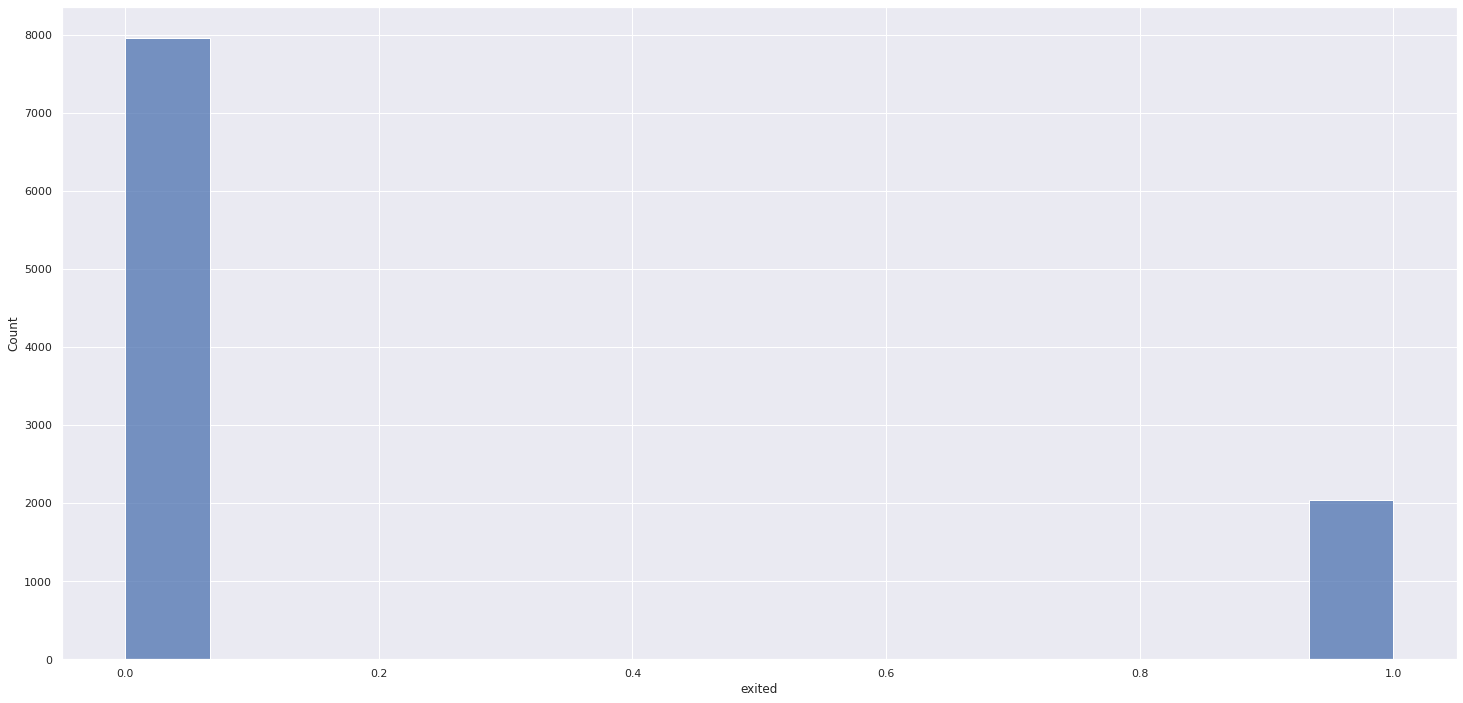

In [15]:
# Interest Variable
sns.histplot(data=df1, x='exited');

## 1.7.2 Categorical Variables

In [16]:
cat_att = df1.select_dtypes(exclude = ['int', 'float'] )
cat_att.columns

Index(['surname', 'geography', 'gender'], dtype='object')

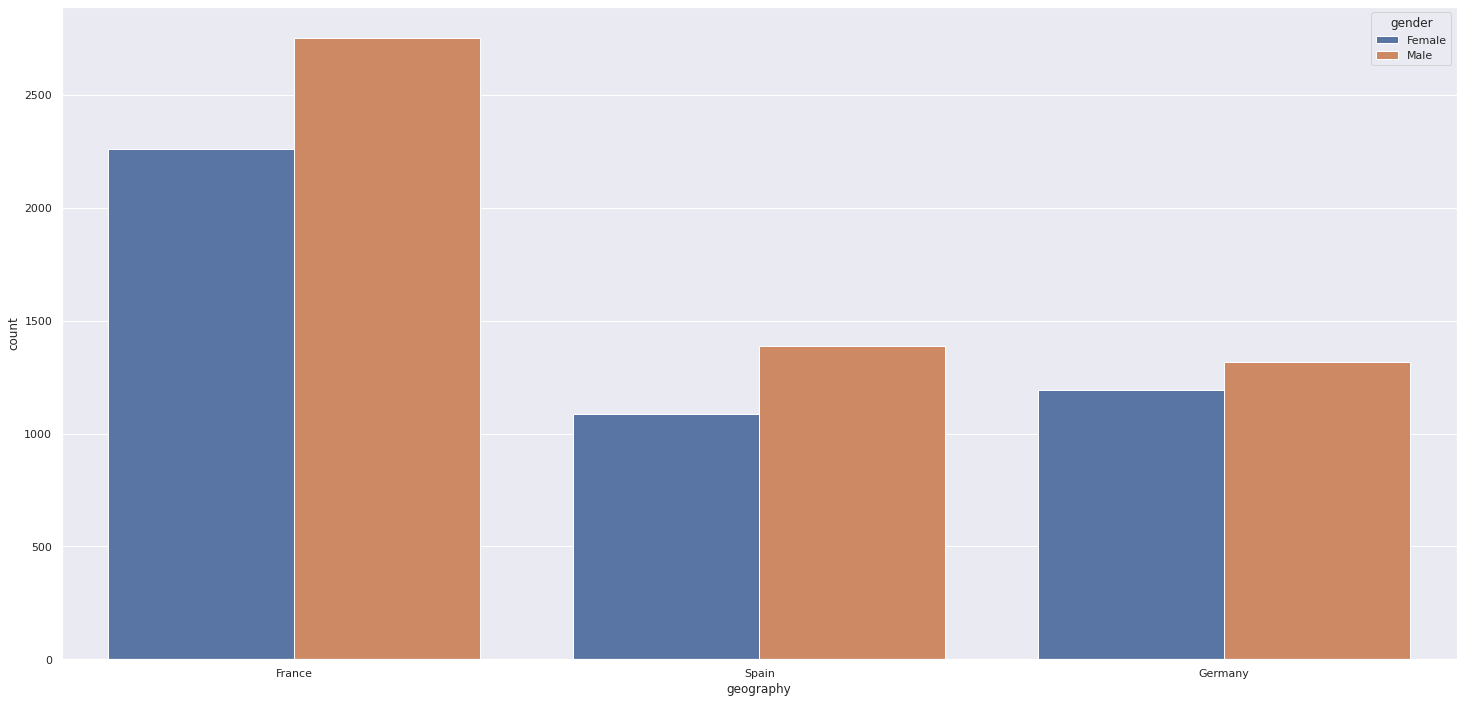

In [17]:
sns.countplot(data = cat_att, x = 'geography', hue = 'gender');

In [18]:
df1.to_csv('../data/interim/df1.csv', index = False )

# 2. Feature Engineering

In [19]:
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'active_member', 'salary', 'exited'],
      dtype='object')

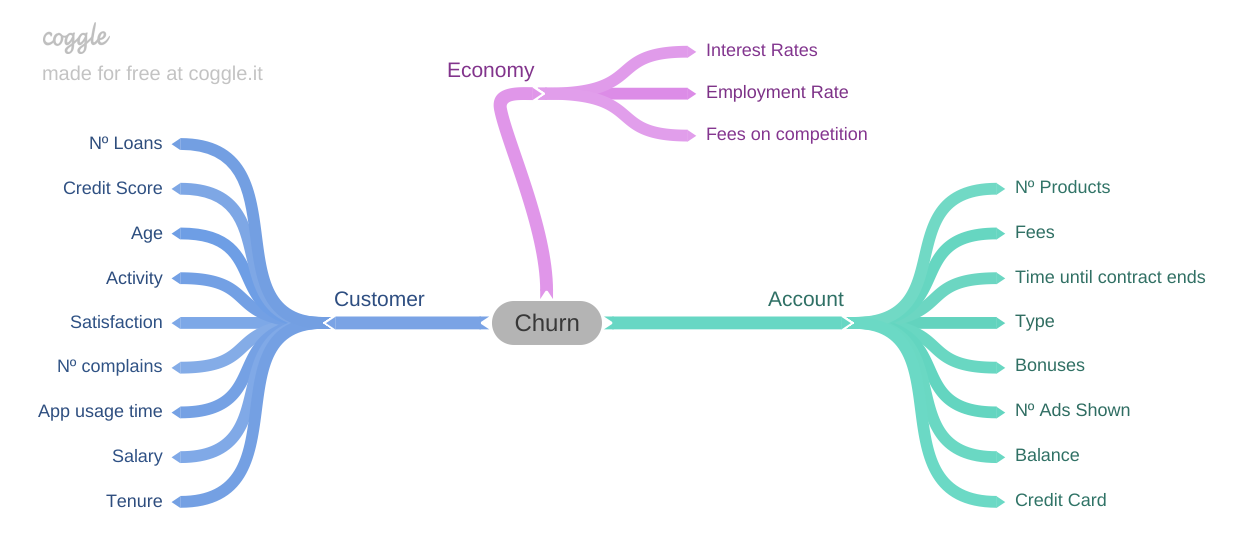

In [20]:
Image('../images/Churn.png')

### Account

Customers paying more fees churn more.

Customers with contracts closer to end churn more.

Customers with accounts more premium churn more.

Customers with more accounts bonuses (or higher tier bonuses) churn less.

**Customers with higher account balance churn less.**

Customers seeing more ads churn more.

**Customers that consume more products churn less**

### Economy.

Customers in debt churn more as interest rates go up.

Customers churn less as the employment rate increases.

Customers offered more benefits from competition churn more.

### Customer.

**Higher credit-scored customers churn less.**

**Younger customers churn more.**

More active customers churn less.

Customers with higher satisfaction churn less.

Customers that made more complaints churn more.

Customers with higher app usage time churn more.

**Customers with higher salaries churn less.**

**Customers with higher tenure churn less.**

**Country matters in customer churn**

**Genter matters in customer churn**

**Customers who have a credit card churn less**

In [21]:
df4.columns

NameError: name 'df4' is not defined

### Selected Hypothesis

**H1.** Customers with higher account balance churn less.

**H2.** Customers that consume more products churn less

**H3.** Higher credit-scored customers churn less.

**H4.** Younger customers churn more.

**H5.** Customers with higher salaries churn less.

**H6.** Customers with higher tenure churn less.

**H7.** Country matters in customer churn

**H8.** Genter matters in customer churn

**H9.** Customers who have a credit card churn less

# 3. Data Filtering

# 4. Exploratory Data Analysis

In [66]:
df4 = pd.read_csv( '../data/interim/df1.csv')

## 4.1 Univariate Analysis


### 4.1.1 Response Variable


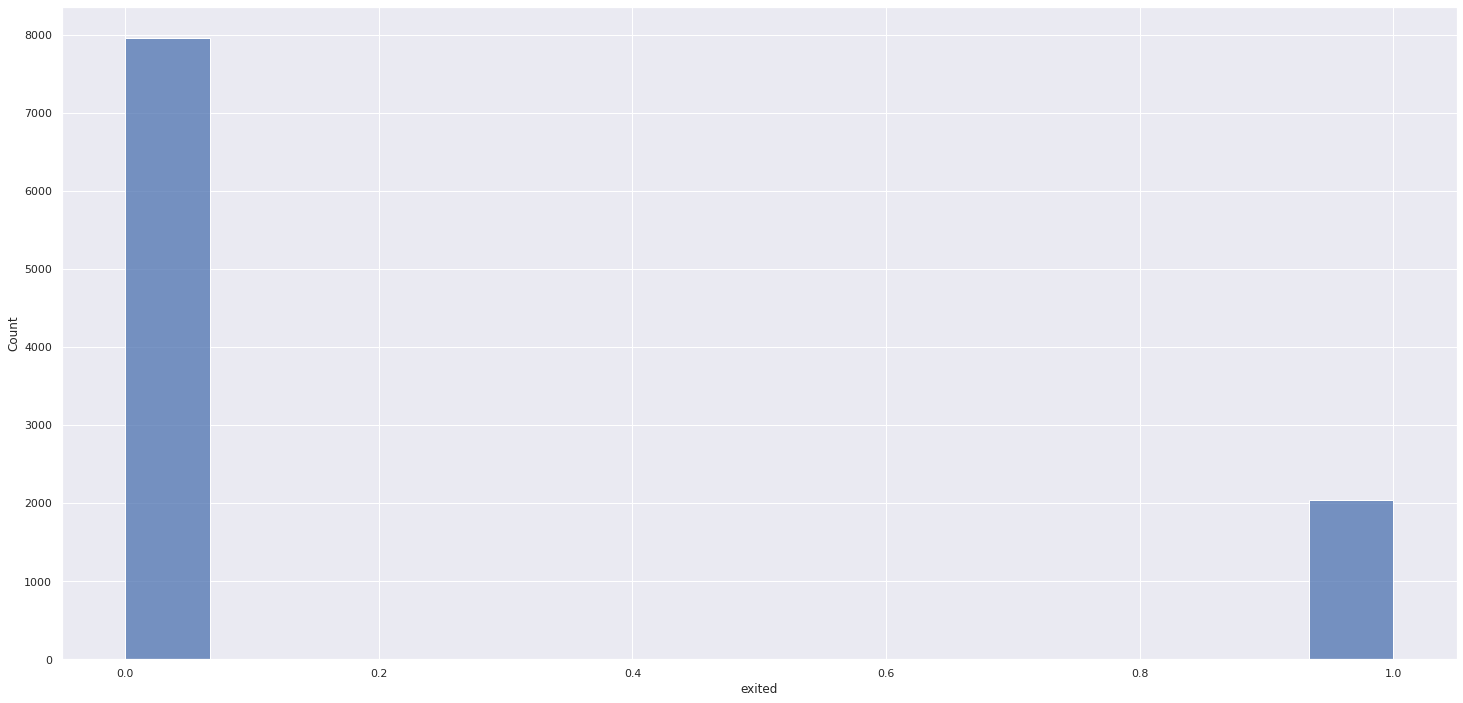

In [ ]:
sns.histplot(data = df4, x = 'exited');

20% of custumers did churn

### 4.1.2 Numerical Variables


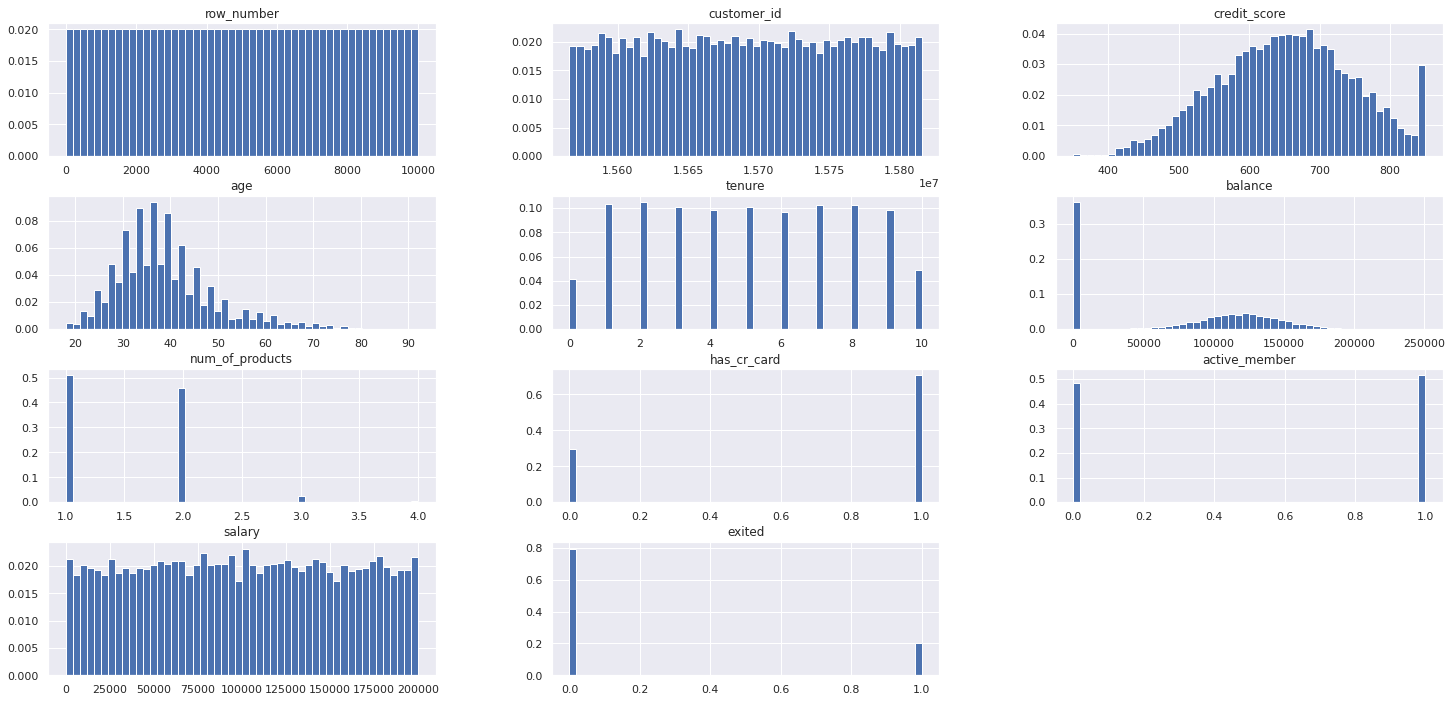

In [ ]:
# weighting data with 1/n to get percentages
num_att = df4.select_dtypes(include = ['int', 'float'] )
num_att.hist( bins = 50, weights = np.ones( len(df4) )/ len(df4) );

- ### credit_score: a few customers (4%) have the highest credit score
- ### age: most customers age between 30 and 40 years old
- ### tenure: customers are evenly spred from 1 to 9 years
- ### balance: almost 40% of users have no money in their account
- ### num_of_products: very few customers consume more than 2 products
- ### has_cr_card: 30% of users have no credit card
- ### active_member: almost half of the customers has not used touched their account in the last 12 months
- ### salary: evenly distributed from 0 to $ 200,000
- ### exite: 20% of users in the dataset left churned

### 4.1.3 Categorical Variables


In [ ]:
aux1 = df1[['exited', ]]

## 4.2 Bivariate Analysis


### **H1.** Customers with higher account balance churn less.
**False**: Customers churn no matter the balance

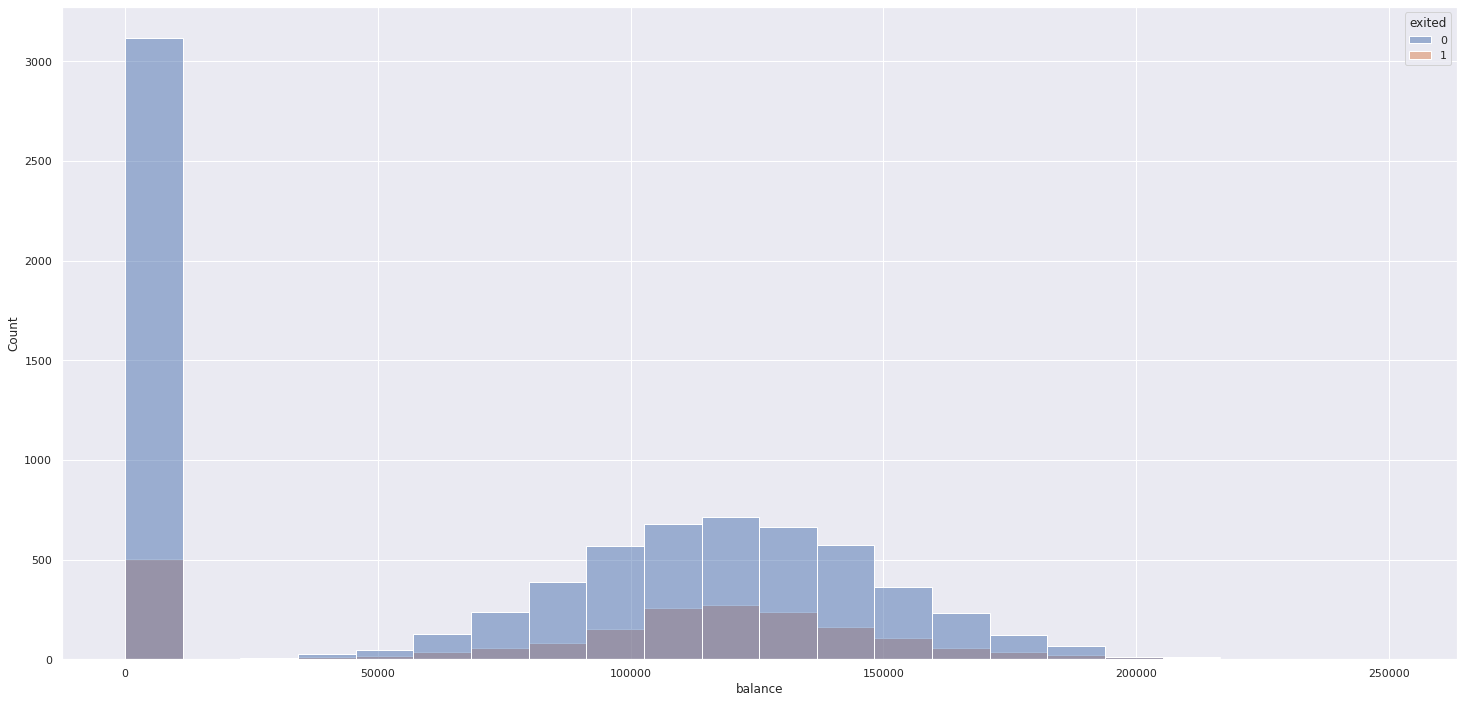

In [ ]:
aux = df4[['exited', 'balance']].copy()
sns.histplot(data = aux, x = 'balance', hue = 'exited');

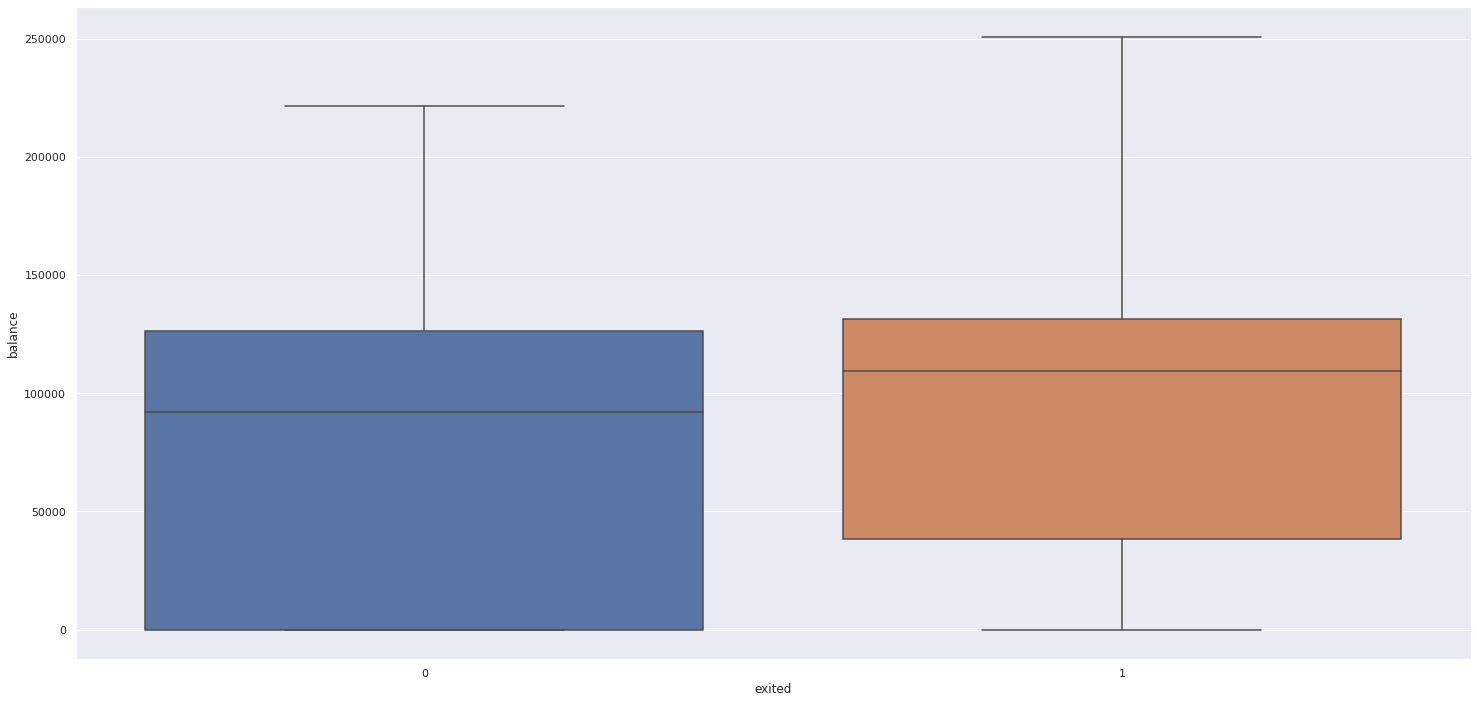

In [ ]:
sns.boxplot(data = aux, x = 'exited', y = 'balance');

In [ ]:
import statsmodels.api as sm

X_train = aux[['balance']]
y_train = aux[['exited']]

# the order is (y, X): endogenous/dependent, exogenous/independent
log_reg = sm.Logit(y_train, X_train).fit()
print(log_reg.summary())

# I attempted to conduce a hypothesis test that showed there is no correlation between the variables

Optimization terminated successfully.
         Current function value: 0.609022
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 exited   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9999
Method:                           MLE   Df Model:                            0
Date:                Mon, 22 Nov 2021   Pseudo R-squ.:                 -0.2048
Time:                        16:57:33   Log-Likelihood:                -6090.2
converged:                       True   LL-Null:                       -5054.9
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
balance    -9.076e-06   2.42e-07    -37.574      0.000   -9.55e-06    -8.6e-06


### **H2.** Customers that consume more products churn less
**Inconclusive**: It appears customers that consume more products indeed churn less (compare 1 to 2 products' bars)

However there is a signifcant amount of customers who consume 3 or 4 products and churn, while there is not data about not churning customers consuming this amount of products.

 More data should be gattered about this before we can conclude about the assumption

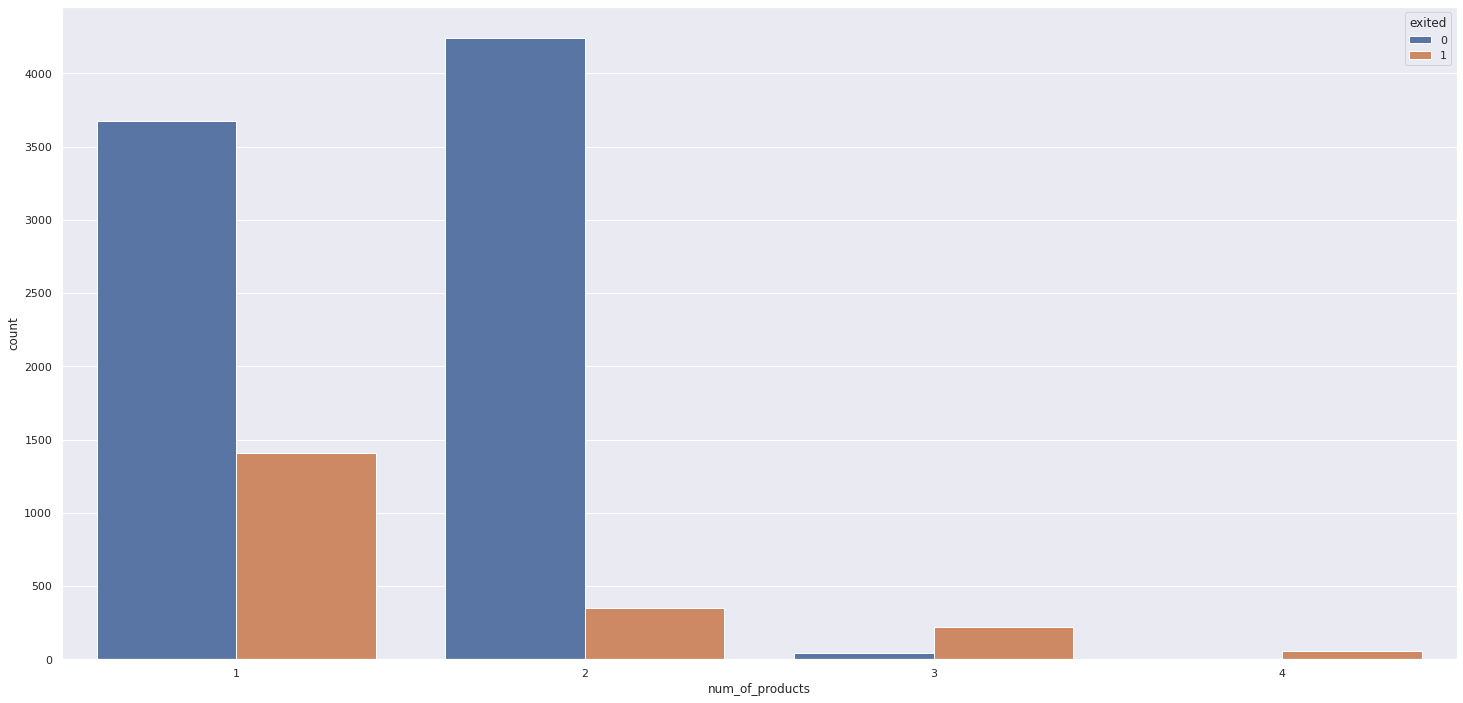

In [ ]:
aux = df4[['exited', 'num_of_products']].copy()
#aux = aux.loc[ aux['num_of_products'] > 1 ]
sns.countplot(data = aux, x = 'num_of_products', hue = 'exited' );


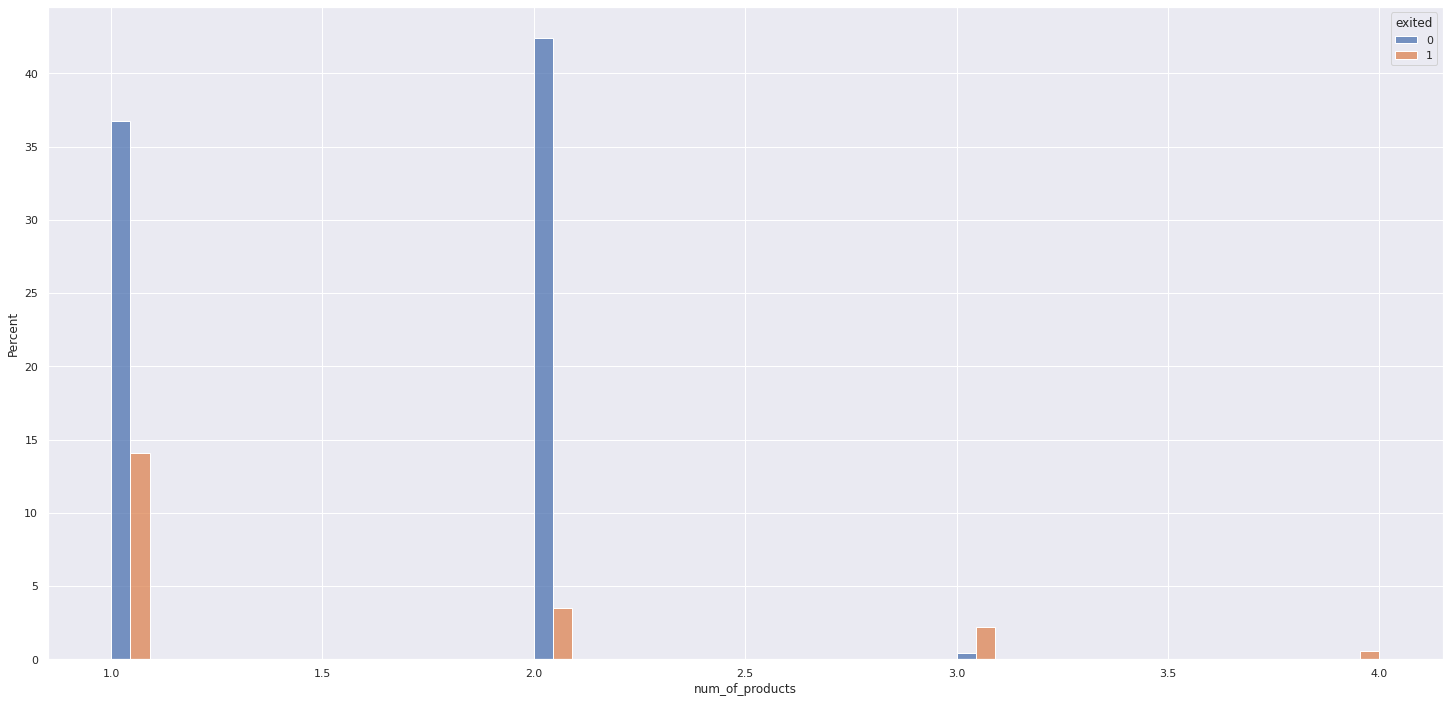

In [ ]:
aux = df4[['exited', 'num_of_products']].copy()
#aux = aux.loc[ aux['num_of_products'] > 1 ]
sns.histplot(data = aux, x = 'num_of_products', hue = 'exited',  stat = 'percent', multiple = 'dodge' );


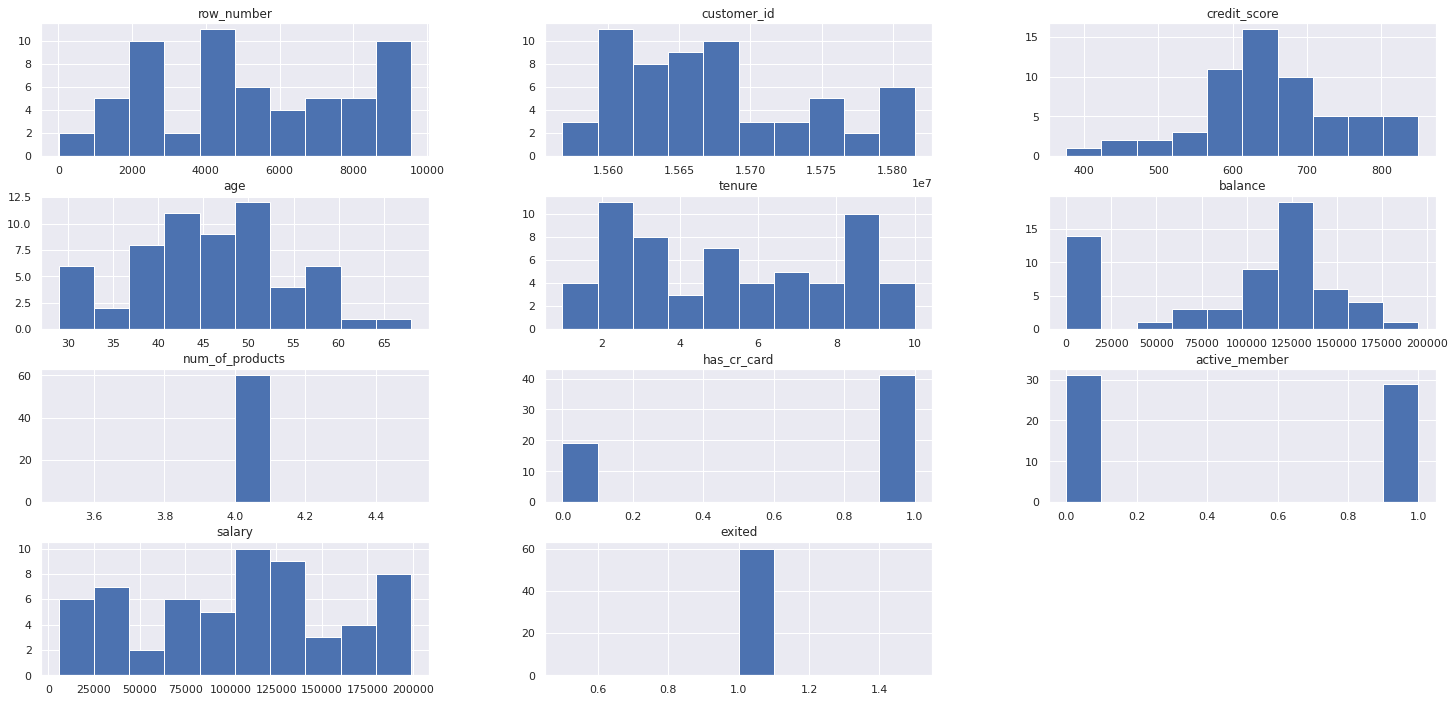

In [ ]:
# investigating, nothing seems to be out of normal.
aux2 = df4.loc[ df4['num_of_products']== 4 ]
aux2.hist();

### **H3.** Higher credit-scored customers churn less.
**False**: Clients from all credit-score values are churning

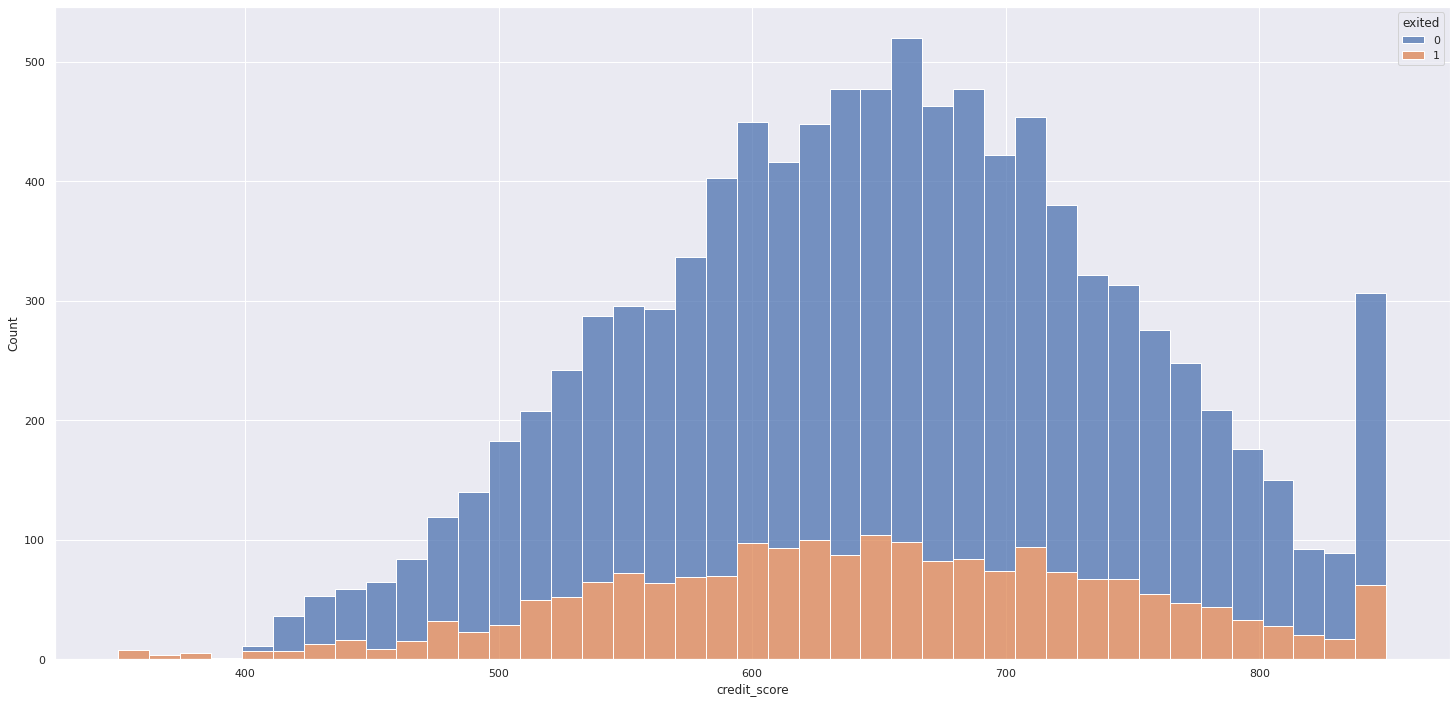

In [70]:
aux = df4[['exited', 'credit_score']]
sns.histplot(data = aux, x = 'credit_score', hue = 'exited', multiple = 'stack');

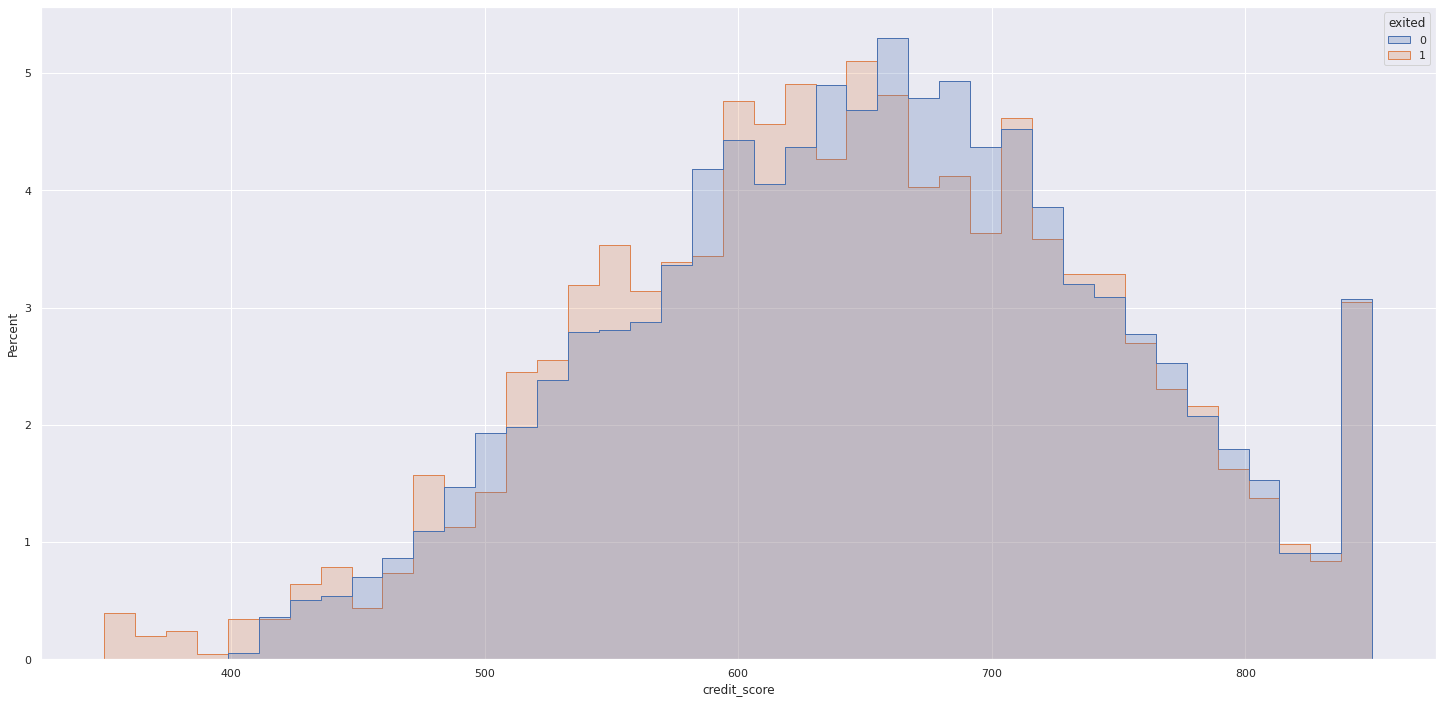

In [78]:
# normalizing separately
aux = df4[['exited', 'credit_score']]
sns.histplot(data = aux, x = 'credit_score', hue = 'exited', stat='percent', element = 'step', common_norm= False); 


### **H4.** Younger customers churn more.
**False**: The highest percentages of churn are observed in customers above 40 years old

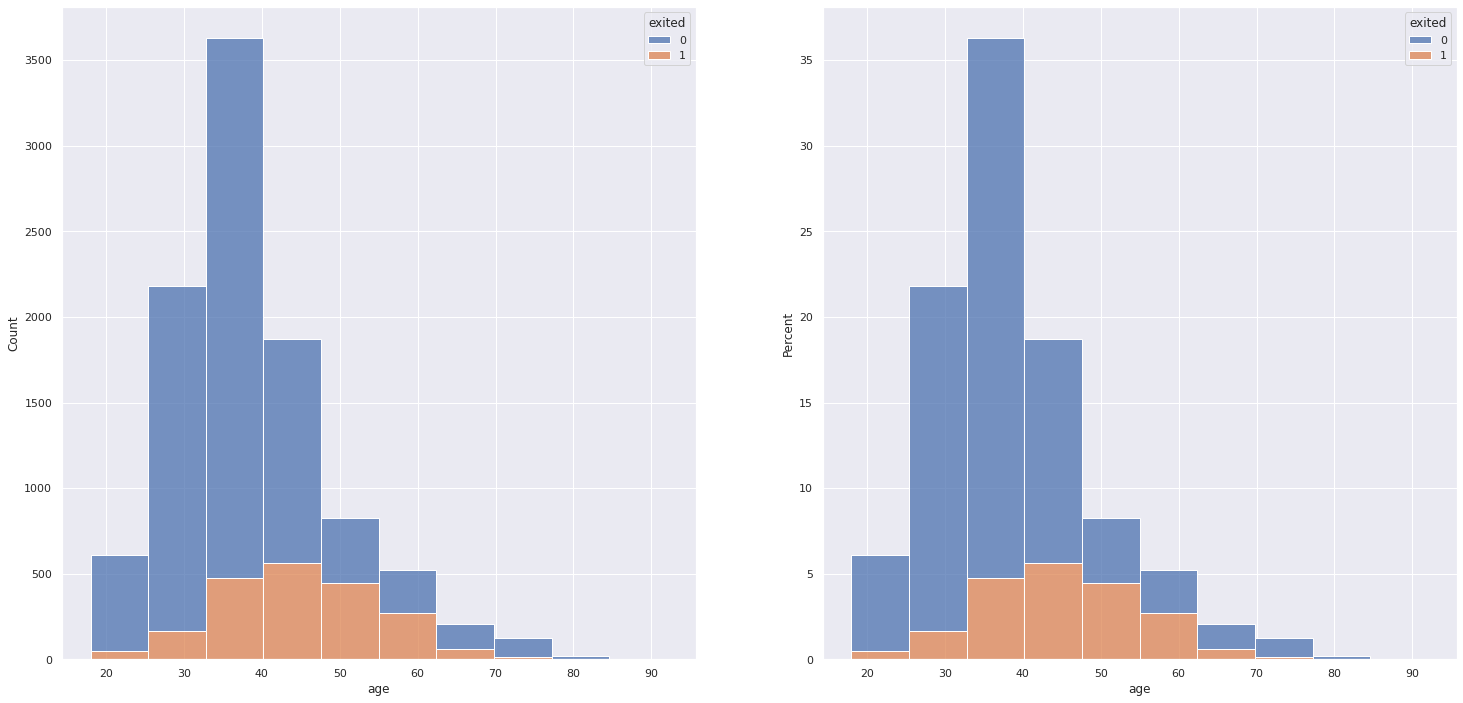

In [ ]:
aux = df4[['exited', 'age']]

plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'age', hue = 'exited', multiple = 'stack', bins = 10);

plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'age', hue = 'exited', multiple = 'stack', stat = 'percent', bins = 10);

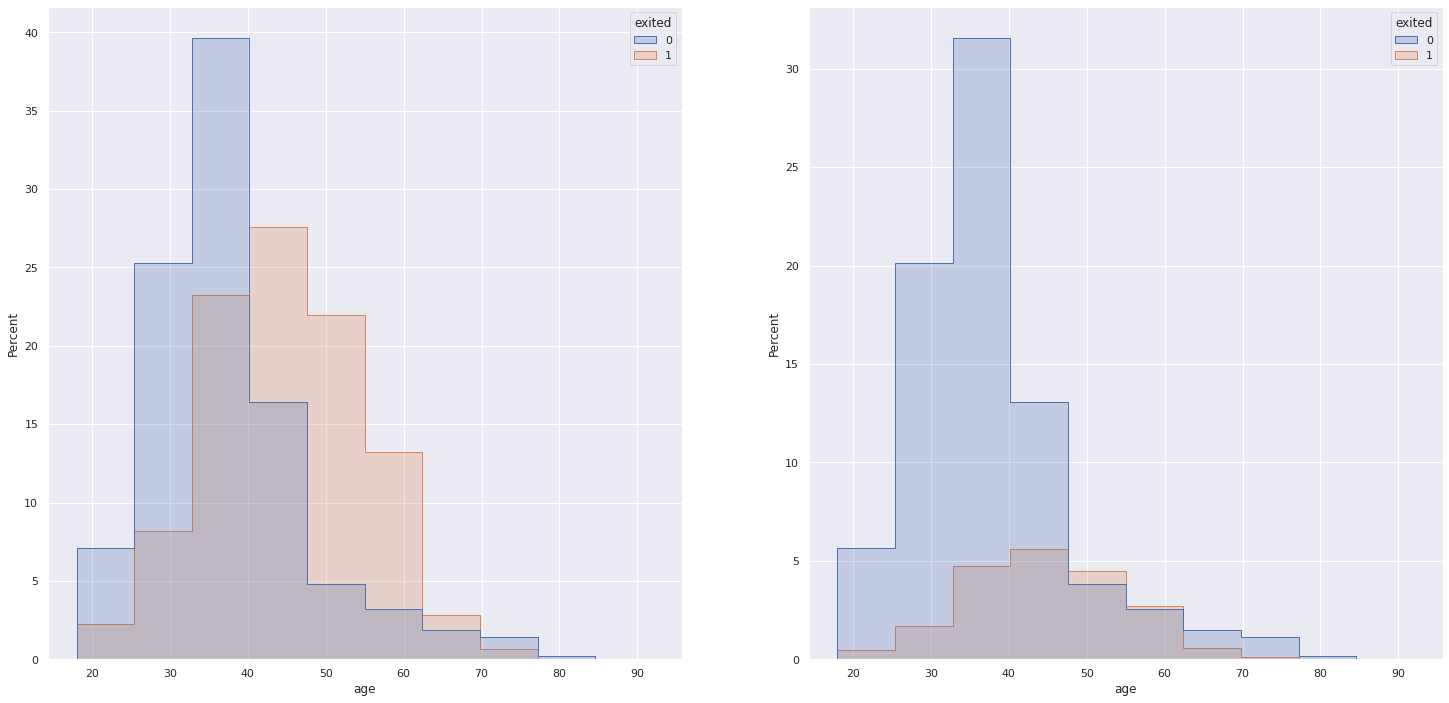

In [ ]:
aux = df4[['exited', 'age']]

# Normalizes considering each class
plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'age', hue = 'exited', element='step', bins = 10, stat = 'percent', common_norm= False );

# Normalizes considering all data
plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'age', hue = 'exited', element='step', bins = 10, stat = 'percent', common_norm= True );

# In relative terms (considering percentage per class) customers older than 50 years old are more likely to churn

### **H5.** Customers with higher salaries churn less.
**False**: Salary appears not to be related to churn.

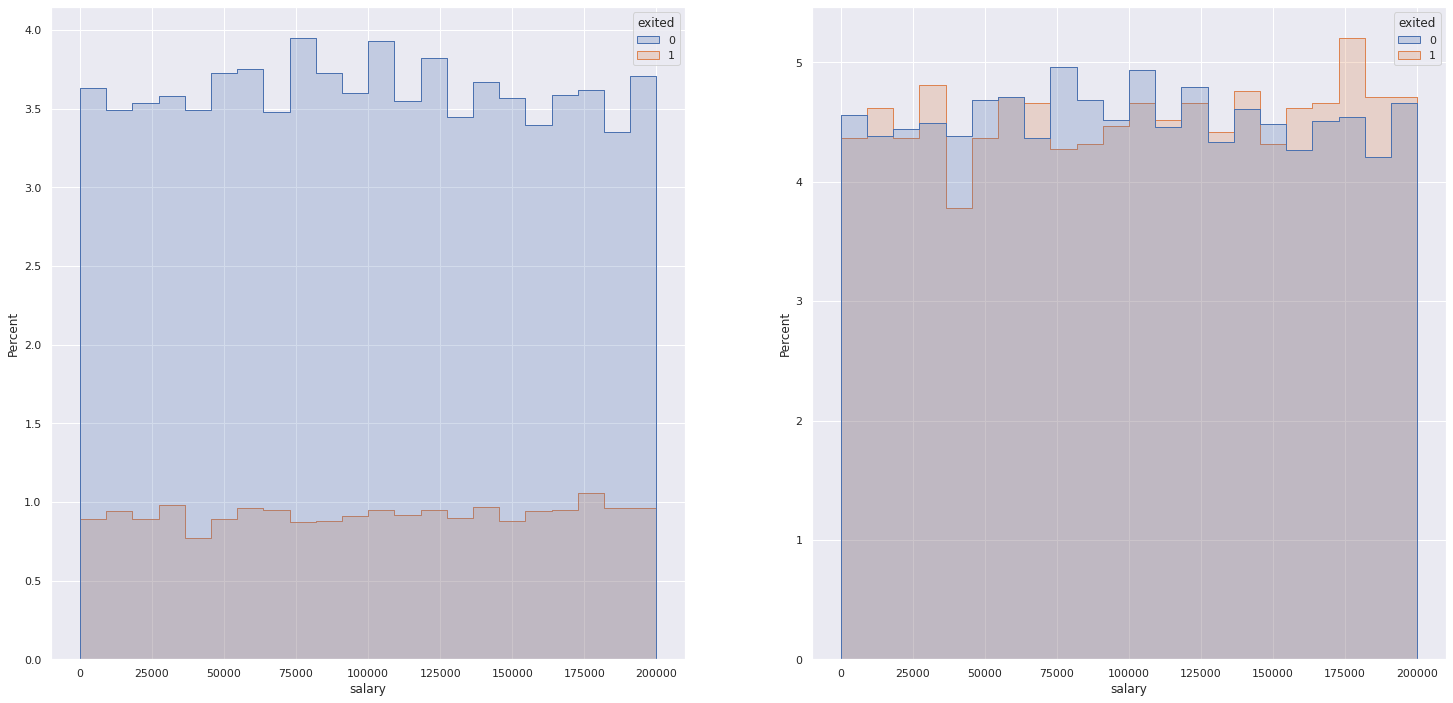

In [ ]:
aux = df4[['exited', 'salary']]

#sns.boxplot(data = aux, x = 'exited', y = 'salary' );
plt.subplot(1,2,1)
sns.histplot(data = aux, x = 'salary', hue = 'exited', element = 'step', stat = 'percent' );

plt.subplot(1,2,2)
sns.histplot(data = aux, x = 'salary', hue = 'exited', element = 'step', stat = 'percent', common_norm = False );


### **H6.** Customers with higher tenure churn less.
**False**: Customers from all tenure values may churn.

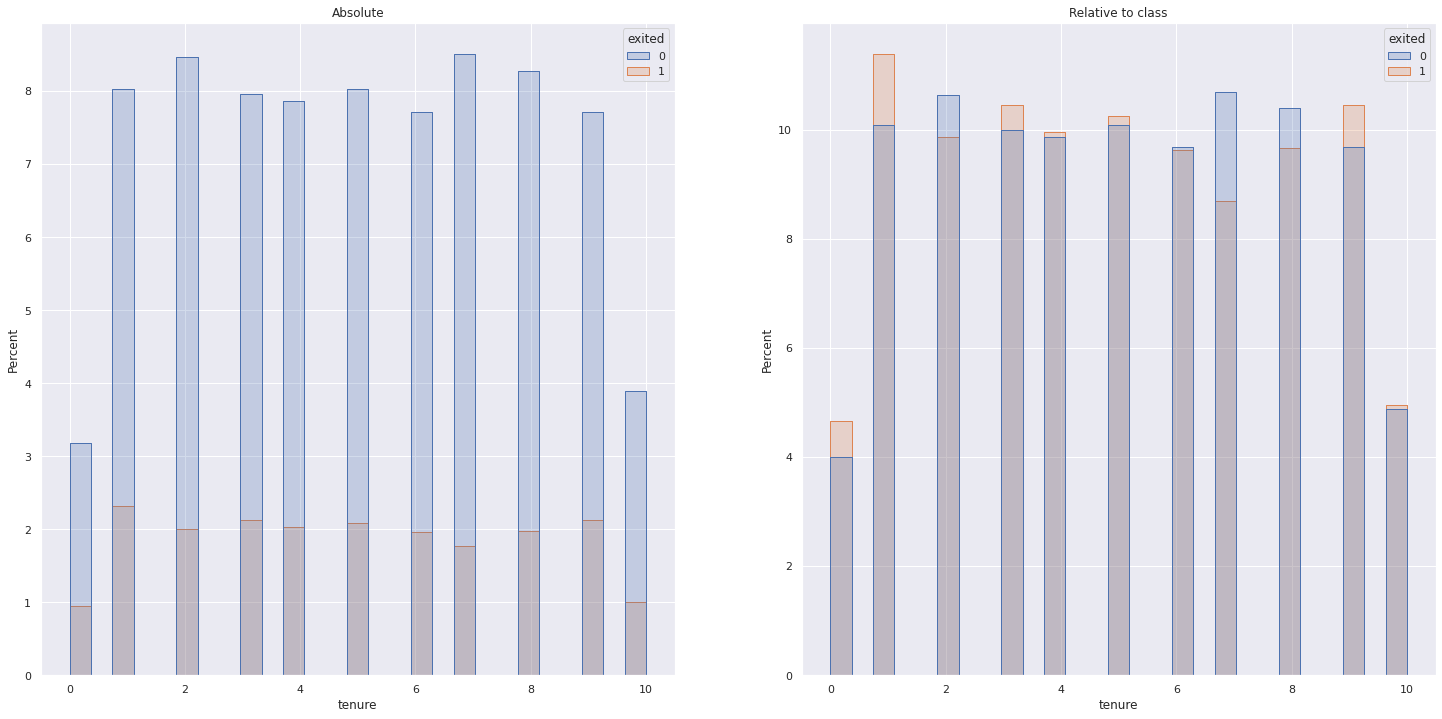

In [ ]:
aux = df4[['exited', 'tenure']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'tenure', hue = 'exited', element = 'step', stat = 'percent' );

plt.subplot(1,2,2)
plt.title('Relative to class')
sns.histplot(data = aux, x = 'tenure', hue = 'exited', element = 'step', stat = 'percent', common_norm = False );

### **H7.** Country matters in customer churn
**True**: French customers present the lowest churn rates, while German customers churn a lot more

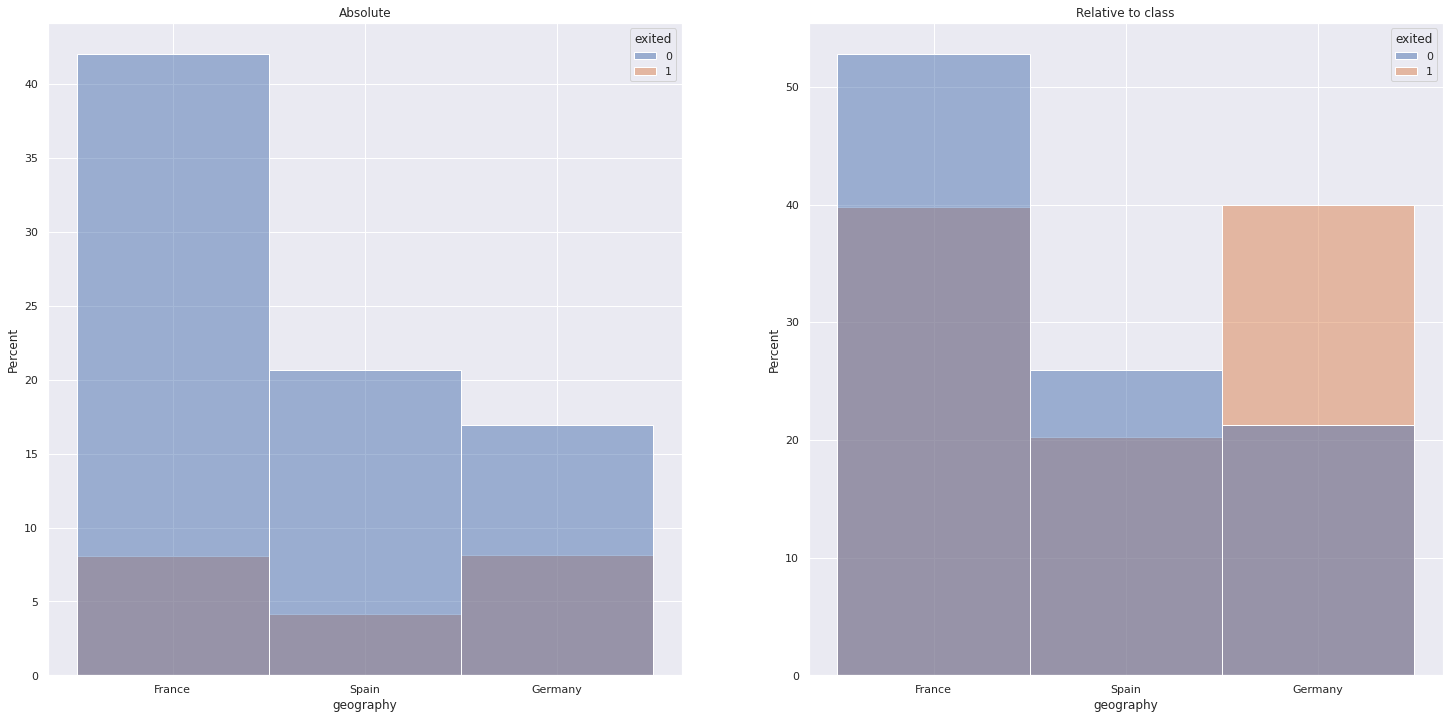

In [ ]:
aux = df4[['exited', 'geography']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat = 'percent' );

plt.subplot(1,2,2)
plt.title('Relative to class')
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat = 'percent', common_norm= False );

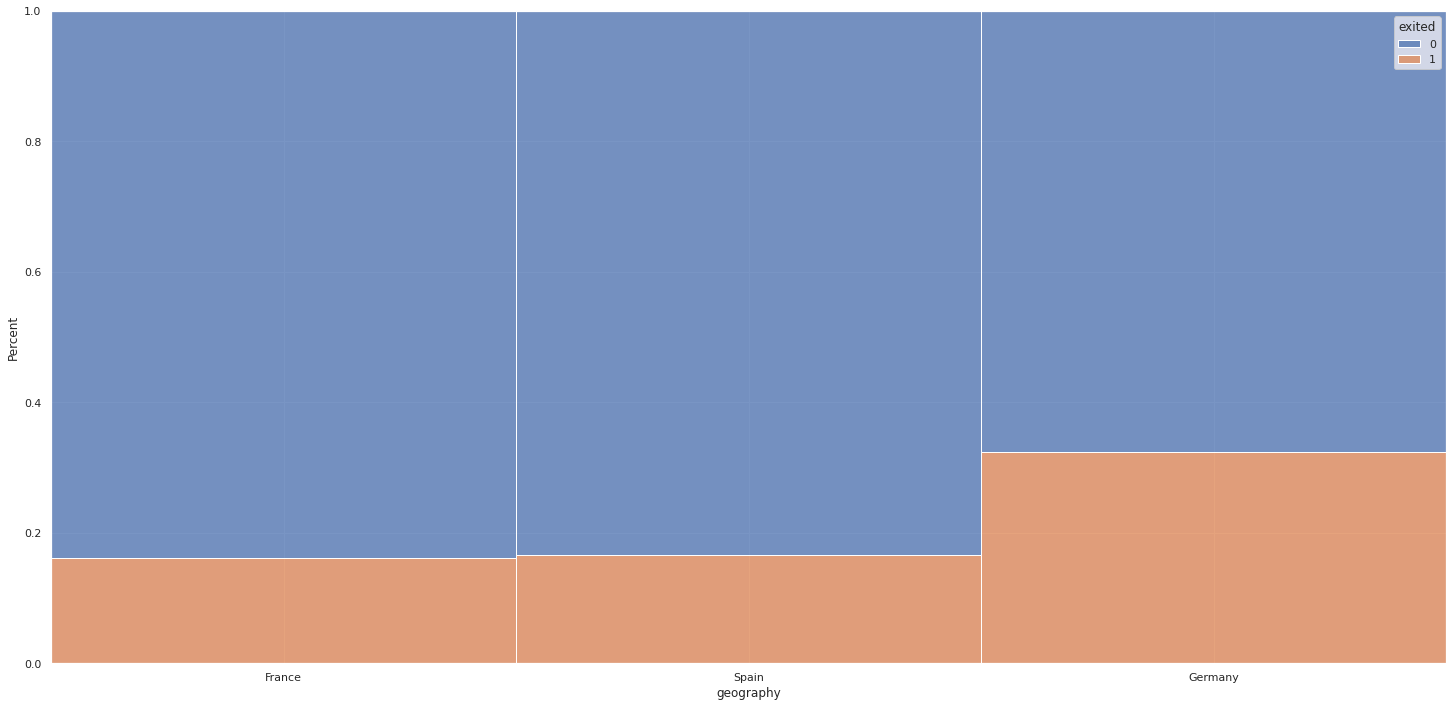

In [ ]:
sns.histplot(data = aux, x = 'geography', hue = 'exited', stat= 'percent', multiple = 'fill' );
# almost 40% of German customers churned

### **H8.** Gender matters in customer churn
**True**: Female customers respond to 55% of the churns observed

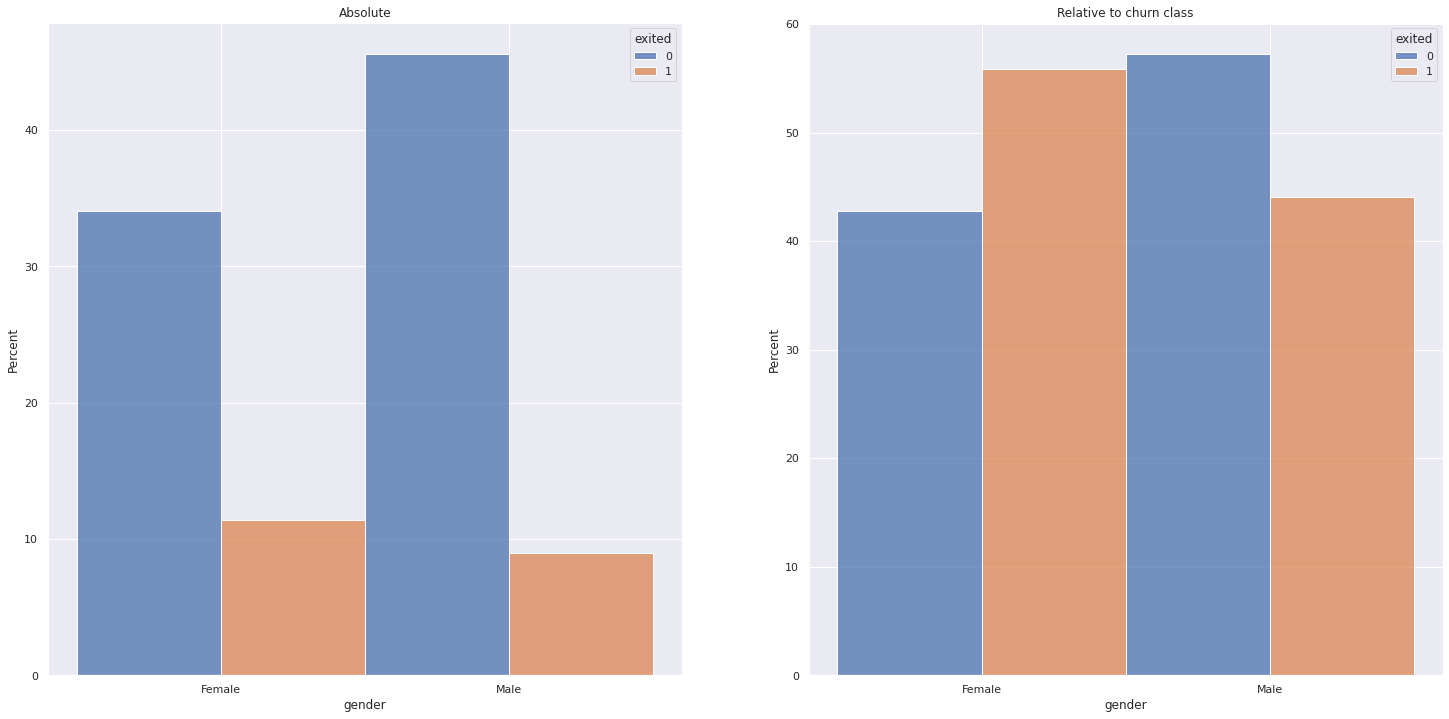

In [ ]:
aux = df4[['exited', 'gender']].copy()

plt.subplot(1,2,1)
plt.title('Absolute')
sns.histplot(data = aux, x = 'gender', hue = 'exited', stat = 'percent', multiple = 'dodge' );

plt.subplot(1,2,2)
plt.title('Relative to churn class')
sns.histplot(data = aux, x = 'gender', hue = 'exited', stat = 'percent', multiple = 'dodge', common_norm= False );

### **H9.** Customers who have a credit card churn less
**False**: Churn rates are identical whether or not a customer possesses a credit card

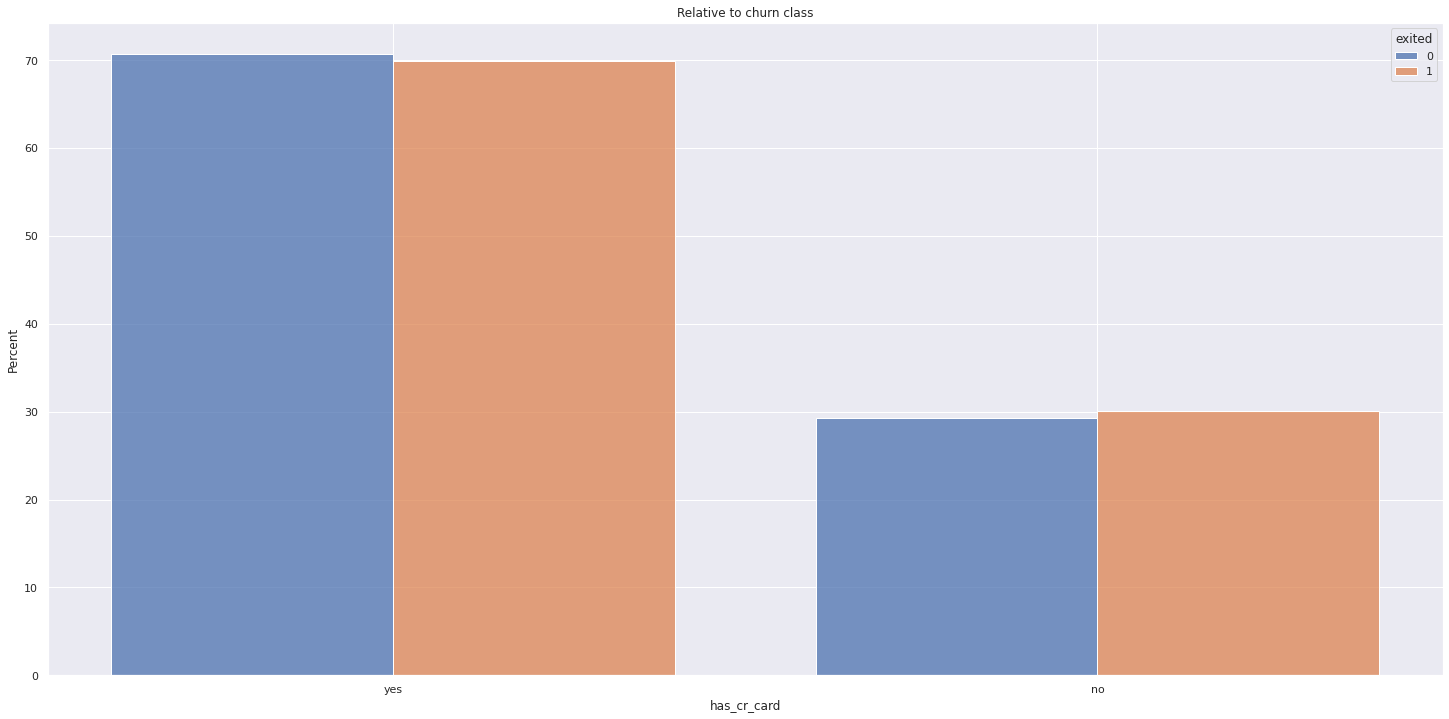

In [ ]:
aux = df4[['exited', 'has_cr_card']].copy()
aux.has_cr_card = aux.has_cr_card.apply(lambda x: 'yes' if x==1 else 'no')
plt.title('Relative to churn class')
sns.histplot(data = aux, x = 'has_cr_card', hue = 'exited', multiple='dodge', stat = 'percent', common_norm= False, shrink=0.8);


    In all countries women are more likely to churn

## 4.3 Multivariate Analisys

### 4.3.1 Numerical Attributes

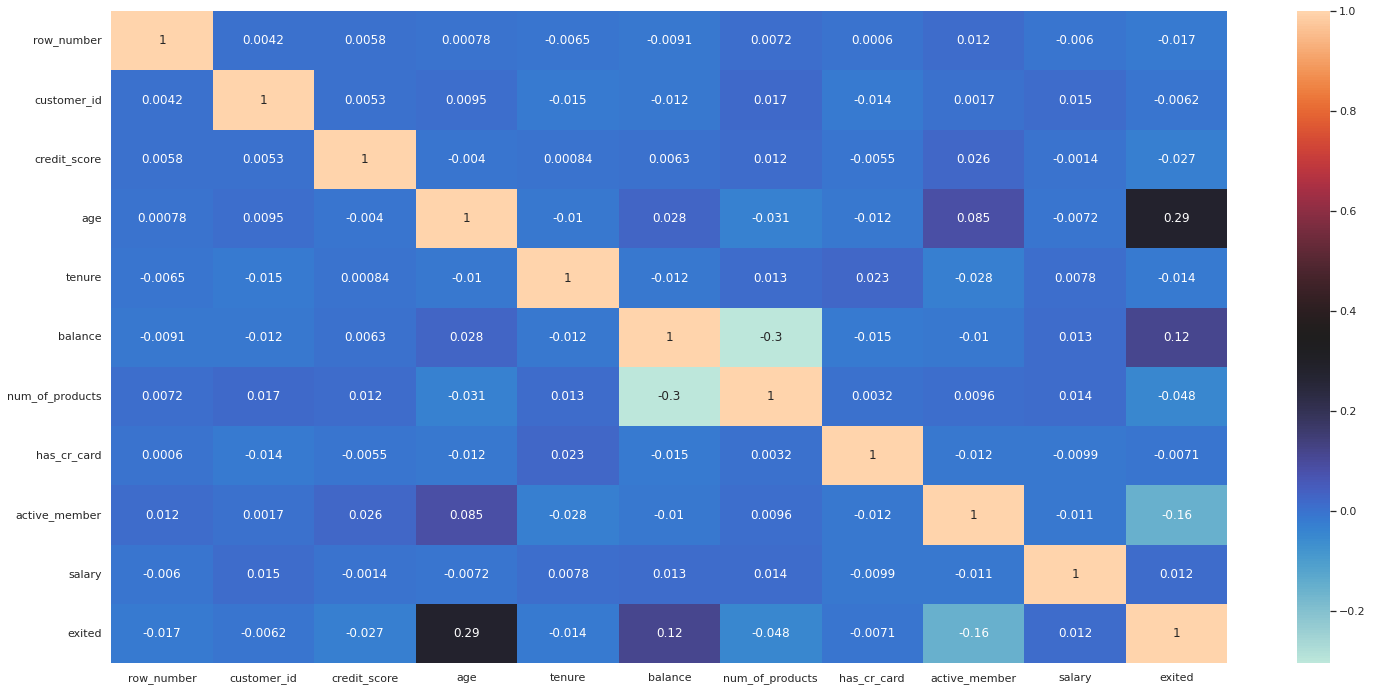

In [ ]:
correlation = num_att.corr( method= 'pearson' )
sns.heatmap(correlation , annot = True, cmap = 'icefire');


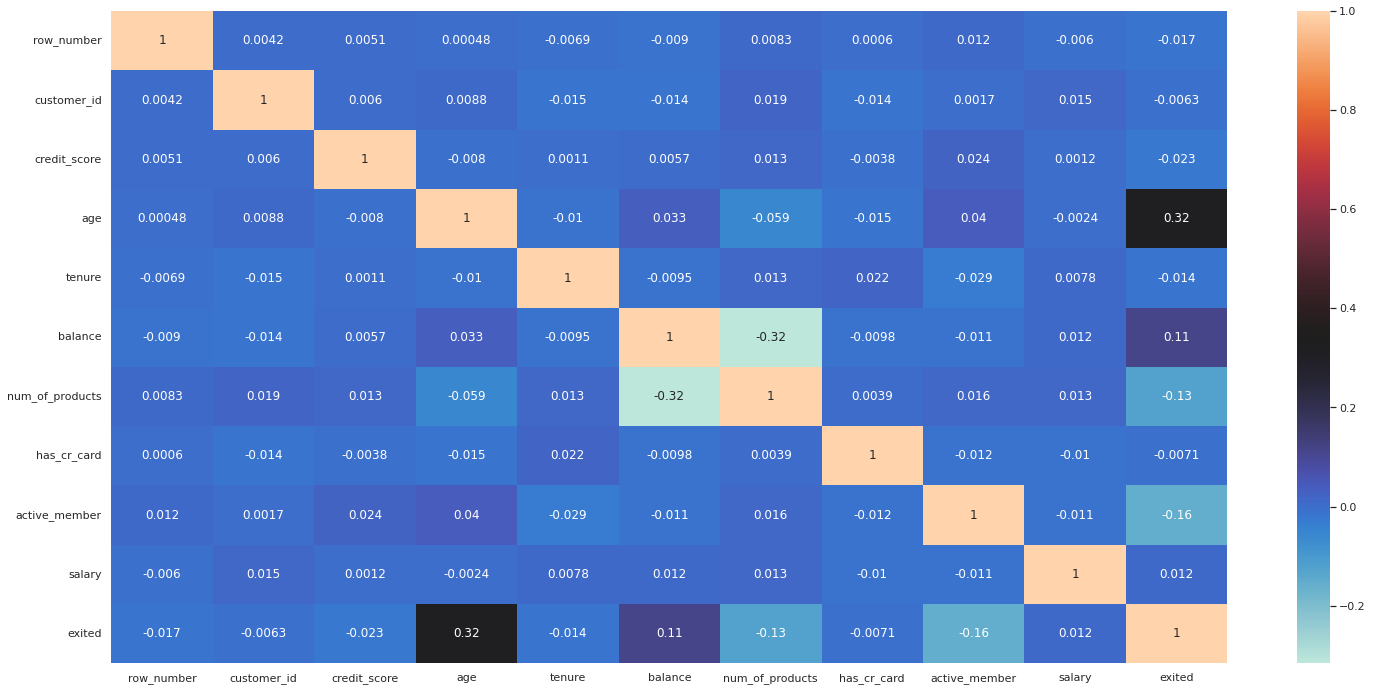

In [ ]:
correlation = num_att.corr( method= 'spearman' )
sns.heatmap(correlation , annot = True, cmap = 'icefire');
# monotonic relations are not stronger than linear ones

As age increases, so does probability of churn. Same for balance.

For activity is the oposite. The more a customer utilizes their account, the less likely they are to churn, however this relationship is not very strong.

Salary, credit card, tenure and credit score show no linear or monotonic relationships

### 4.3.2 categorical Attributes

Not interested in correlation between gender and country

# 5. Data Preparation

### Solution Planing:
#### Data Prep
- Separate a representative test set (20% of the data)
- Apply 1 oversampling
- Build pipeline to automate processes (over/undersampling -> crossvalidation -> model fit)

I'm removing row_number and customer_id since these features: 
- should not help in predicting churn 
- may leak data
- can make the algorithms learn which customers churn based on row.

Concerning number of products, it doesn't make sense that customers that acquire 3 or more products automatically churn. Should that be the case, we could simply stop selling 3 or more products to customers and stop churn. I'm removing the feature so that models do not learn this.

In [ ]:
#df5 = df4.copy()
df5 = pd.read_csv( '../data/interim/df1.csv' )
df5 = df5.drop(columns = [ 'row_number', 'customer_id', 'surname', 'num_of_products' ], axis = 1)

## 5.1 Train Test Split

In [ ]:
# Selecting X and y
X = df5.iloc[:, :-1].copy()
y = df5.iloc[:, -1].copy()

# spliting train and test datasets
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     shuffle = True, 
                                                     stratify = y ) # stratify train and test datasets based on response variable

In [ ]:
print( 'Proportion of 1s in train data: {:,.2f}'.format( Counter(y_train)[1]/Counter(y_train)[0] ) )
print( 'Proportion of 1s in test  data: {:,.2f}'.format( Counter(y_test)[1]/Counter(y_test)[0] ) )

# Stratification followed the expected distributions for train and test sets

Proportion of 1s in train data: 0.26
Proportion of 1s in test  data: 0.26


## 5.2 Categorical Variables Encoding

In [ ]:
# selecting columns to be transformed
cat_columns = ['gender', 'geography']
num_columns = ['credit_score', 'age', 'tenure', 'balance', 'salary']

# Strategy selected to each column
# 'credit_score', 'age', 'tenure', 'balance', 'salary'  | minmax
# 'has_cr_card', 'active_member'              | nothing

# Defining transformers
ohe = OneHotEncoder()
min_max = MinMaxScaler()
preprocessor = ColumnTransformer(
    transformers= [ ('cat', ohe, cat_columns),
                    ('num', min_max, num_columns) ], remainder= 'passthrough' ) 


preprocessing_pipe = Pipeline( steps = [ ('preprocessor', preprocessor) ] )
X_train_t = preprocessing_pipe.fit_transform( X_train )
X_test_t = preprocessing_pipe.transform( X_test )

In [ ]:
#Saving preprocessed data to use on the next steps

#save path
interim_path = '../data/interim/'

pickle.dump(X_train_t, open(interim_path + 'X_train_t.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(X_test_t, open(interim_path + 'X_test_t.pkl', 'wb'),   protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(y_train, open(interim_path + 'y_train.pkl', 'wb'),     protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(y_test, open(interim_path + 'y_test.pkl', 'wb'),       protocol=pickle.HIGHEST_PROTOCOL)

## 5.3 Building the Pipelines

In [ ]:
# Including preprocessing to pipeline:
ada = ADASYN(sampling_strategy= 1.0, random_state = 42)
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 2, random_state= 42)
knn = KNeighborsClassifier()

# Complete pipeline model (that takes unprocessed data)
pipe_complete = imbPipeline(steps = [('preprocessing', preprocessor), ('ada', ada), ('knn', knn)] )
scores = cross_val_score( pipe_complete, X_train, y_train, scoring='recall', cv = cv, n_jobs= -1 )
print(np.mean(scores))

# Reduced pipeline model (that takes processed data) this one is faster
pipe = imbPipeline(steps = [('ada', ada), ('knn', knn)] )
scores = cross_val_score( pipe, X_train_t, y_train, scoring='recall', cv = cv, n_jobs= -1 )
np.mean(scores)

0.5947852760736196


0.5963190184049079

In [ ]:
from imblearn.over_sampling import ADASYN
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
import numpy as np

In [ ]:
ada = ADASYN(sampling_strategy=0.5, random_state=42, n_jobs=-1, n_neighbors=5)
cv =  RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)
knn = KNeighborsClassifier()

# Selecting X and y
X = df5.iloc[:, :-1].copy()
y = df5.iloc[:, -1].copy()

# spliting train and test datasets
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     shuffle = True, 
                                                     stratify = y ) # stratify train and test datasets based on response variable

# creating a pipeline 
pipeline = Pipeline(steps = [('over', ada), ('knn', knn)])

scores = cross_val_score(pipeline, X_train, y_train, scoring = 'recall', cv = cv, n_jobs = -1, verbose = 0)
print(np.mean(scores))


0.25337423312883434


# 6. Feature Selection

In [ ]:
# Including preprocessing to pipeline:
ada = ADASYN(sampling_strategy= 1.0, random_state = 42)
cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 2, random_state= 42)
knn = KNeighborsClassifier()

# Reduced pipeline model (that takes processed data) this one is faster
pipe = imbPipeline(steps = [('ada', ada), ('knn', knn)] )
scores = cross_val_score( pipe, X_train_t, y_train, scoring='recall', cv = cv, n_jobs= -1 )
np.mean(scores)

0.5963190184049079

In [ ]:
# getting column names from preprocessor
columns_names = list(preprocessing_pipe[0].get_feature_names_out())
columns_names

# Defining X_train and y_train for boruta
X_train_boruta = pd.DataFrame(X_train_t, columns = columns_names)
y_train_boruta = y_train


In [ ]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators= 100, max_depth= 5, class_weight= 'balanced', n_jobs= -1)

feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)


X_train_boruta = X_train_boruta.values
y_train_boruta = y_train.values.ravel()

# find all relevant features - 5 features should be selected
feat_selector.fit(X_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	3
Iteration: 	9 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	3
Iteration: 	10 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	3
Iteration: 	11 / 100
Confirmed: 	7
Tentative: 	2
Rejected: 	3
Iteration: 	12 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	3
Iteration: 	13 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	3
Iteration: 	14 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	3
Iteration: 	15 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	3
Iteration: 	16 / 100
Confirmed: 	8
Tentative: 	1
Rejected: 	3
Iteration:

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=84, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7F805AA0E140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F805AA0E140, verbose=2)

In [ ]:
rank_n = list(feat_selector.ranking_)
cols = columns_names
ranking = list( zip(cols, rank_n) )
ranking = sorted(ranking, key = lambda x:x[1] )
print( 'Feature importance according to Boruta, rank higher = lower importance')
for feat in ranking:
    print( 'feature: {:<25} rank: {}'.format(feat[0], feat[1]) )
# Reading Output From Boruta

i = 0
cols_selected = []
cols_not_selected = []
for elem in feat_selector.support_:
    if elem: #if True in support_, column was selected
        cols_selected.append(columns_names[i])
    else:
        cols_not_selected.append(columns_names[i])
    i +=1    
print( '\nColumns Selected by Boruta: ')
print( cols_selected )
print( '\nColumns Not Selected by Boruta: ')
print( cols_not_selected )


Feature importance according to Boruta, rank higher = lower importance
feature: cat__gender_Female        rank: 1
feature: cat__gender_Male          rank: 1
feature: cat__geography_France     rank: 1
feature: cat__geography_Germany    rank: 1
feature: num__credit_score         rank: 1
feature: num__age                  rank: 1
feature: num__balance              rank: 1
feature: num__salary               rank: 1
feature: remainder__active_member  rank: 1
feature: cat__geography_Spain      rank: 2
feature: num__tenure               rank: 3
feature: remainder__has_cr_card    rank: 4

Columns Selected by Boruta: 
['cat__gender_Female', 'cat__gender_Male', 'cat__geography_France', 'cat__geography_Germany', 'num__credit_score', 'num__age', 'num__balance', 'num__salary', 'remainder__active_member']

Columns Not Selected by Boruta: 
['cat__geography_Spain', 'num__tenure', 'remainder__has_cr_card']


Columns Selected by Boruta: 

['cat__gender_Female', 'cat__gender_Male', 'cat__geography_France', 'cat__geography_Germany', 'num__credit_score', 'num__age', 'num__balance', 'num__salary', 'remainder__active_member']

Columns Not Selected by Boruta: 

['cat__geography_Spain', 'num__tenure', 'remainder__has_cr_card']

### Features Boruta Rejected:
- ###  country = Spain: Will include in the training data models
- ###  tenure: Will include in this CRISP cycle, if not important we can remove in next cycle
- ###  has credit card: Won't include in this CRISP cycle

# 7. Machine Learning Modelling

#### Solution Planing:
- Baseline: No under/oversampling 

- Apply 6 oversampling methods
    - Random Oversampling
    - SMOTE    
    - ADASYN
    - Borderline SMOTE
    - KMeans SMOTE
    - SVM SMOTE
- Apply 6 undersampling methods
    - Random Undersampling
    - Near Miss
    - Tomek's Links
    - RepeatedEditedNearestNeighbours
    - Neighborhood Cleaning Rule (NCR)
- Apply 3 combined methods
    - Random Undersampling and Random Oversampling
    - SMOTE and Tomek
    - SMOTE and KNN

#### Using:
- KNN

#### ML Test
- Apply 2 linear
    - Logistic Regression
    - SVM (sklearn.svm.SVC)
- Apply 3 trees
    - Random Forest
    - Balanced RF
- Apply 3 boosted
    - XGBClassifier
    - Catboost
    - LightGBM

No over/under sampling
Random Oversampling and Undersampling
SMOTE and Random Undersampling
SMOTE and Tomek Links Undersampling; imblearn.combine.SMOTETomek
SMOTE and Edited Nearest Neighbors Undersampling; imblearn.combine.SMOTEENN



In [3]:
# Reading data

interim_path = '../data/interim/'
X_train_t = pickle.load( open(interim_path + 'X_train_t.pkl', 'rb'))
X_test_t = pickle.load( open(interim_path + 'X_test_t.pkl', 'rb'))
y_train = pickle.load( open(interim_path + 'y_train.pkl', 'rb'))
y_test = pickle.load( open(interim_path + 'y_test.pkl', 'rb'))

print( 'Proportion of 1s in train data: {:,.2f}'.format( Counter(y_train)[1]/Counter(y_train)[0] ) )
print( 'Proportion of 1s in test  data: {:,.2f}'.format( Counter(y_test)[1]/Counter(y_test)[0] ) )


Proportion of 1s in train data: 0.26
Proportion of 1s in test  data: 0.26


## 7.1 Sampling Methods Comparison

In [ ]:

# Defining Model to test preprocessings
KNN = KNeighborsClassifier()

# No Sampling
pipe = imbPipeline(steps = [('KNN', KNN)] )
r1 = eval_model_cv(pipe, X_train_t, y_train, 'No Sampling', 5, 5 )

# Random Oversampling
over = RandomOverSampler(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('over', over), ('KNN', KNN)] )
r2 = eval_model_cv(pipe, X_train_t, y_train, 'Random Oversampling', 5, 5 )

# SMOTE    
smt = SMOTE(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('smt', smt), ('KNN', KNN)] )
r3 = eval_model_cv(pipe, X_train_t, y_train, 'SMOTE', 5, 5 )

# ADASYN
ada = ADASYN(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('ada', ada), ('KNN', KNN)] )
r4 = eval_model_cv(pipe, X_train_t, y_train, 'ADASYN', 5, 5 )

# Borderline SMOTE
bor = BorderlineSMOTE(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('ada', bor), ('KNN', KNN)] )
r5 = eval_model_cv(pipe, X_train_t, y_train, 'BorderlineSMOTE', 5, 5 )

# KMeans SMOTE 
km_smt = KMeansSMOTE(sampling_strategy=1.0, random_state = 42, k_neighbors = 2, cluster_balance_threshold =0)
pipe = imbPipeline(steps = [ ('km_smt', km_smt), ('KNN', KNN)] )
r6 = eval_model_cv(pipe, X_train_t, y_train, 'KMeansSMOTE', 5, 5 )

# SVM SMOTE 
svm_smt = SVMSMOTE(sampling_strategy=1.0, random_state = 42 )
pipe = imbPipeline(steps = [ ('svm_smt', svm_smt), ('KNN', KNN)] )
r7 = eval_model_cv(pipe, X_train_t, y_train, 'SVMSMOTE', 5, 5 )

# Random Undersampling
under = RandomUnderSampler(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('under', svm_smt), ('KNN', KNN)] )
r8 = eval_model_cv(pipe, X_train_t, y_train, 'Random UnderSampling', 5, 5 )

# Near Miss
near = NearMiss(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('NearMiss', near), ('KNN', KNN)] )
r9 = eval_model_cv(pipe, X_train_t, y_train, 'NearMiss', 5, 5 )

# Tomek's Links
tomek = TomekLinks(sampling_strategy='majority')
pipe = imbPipeline(steps = [ ('TomekLinks', tomek), ('KNN', KNN)] )
r10 = eval_model_cv(pipe, X_train_t, y_train, 'TomekLinks', 5, 5 )


# RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
pipe = imbPipeline(steps = [ ('renn', renn), ('KNN', KNN)] )
r11 = eval_model_cv(pipe, X_train_t, y_train, 'RENN', 5, 5 )

# Neighborhood Cleaning Rule (NCR) 

ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
pipe = imbPipeline(steps = [ ('ncr', ncr), ('KNN', KNN)] )
r12 = eval_model_cv(pipe, X_train_t, y_train, 'NCR', 5, 5 )

# Random NearMisssampling and Random Oversampling
over = RandomOverSampler(sampling_strategy = 0.5)
under = RandomUnderSampler(sampling_strategy = 1.0)
pipe = imbPipeline(steps = [ ('over', over), ('under', under), ('KNN', KNN)] )
r13 = eval_model_cv(pipe, X_train_t, y_train, 'Over/Under', 5, 5 )

# SMOTE and Tomek
smt_tomek = SMOTETomek(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('SMOTETomek', smt_tomek), ('KNN', KNN)] )
r14 = eval_model_cv(pipe, X_train_t, y_train, 'SMOTETomek', 5, 5 )

# SMOTE and KNN
smt_enn = SMOTEENN(sampling_strategy=1.0)
pipe = imbPipeline(steps = [ ('SMOTETomek', smt_enn), ('KNN', KNN)] )
r15 = eval_model_cv(pipe, X_train_t, y_train, 'SMOTEENN', 5, 5 )

res = pd.concat( [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15], axis = 0 )


Method: No Sampling               ROC_AUC: 0.6754954685980102
Method: Random Oversampling       ROC_AUC: 0.661756460016758
Method: SMOTE                     ROC_AUC: 0.6712336392792133
Method: ADASYN                    ROC_AUC: 0.6700846567980661
Method: BorderlineSMOTE           ROC_AUC: 0.673945883214069
Method: KMeansSMOTE               ROC_AUC: 0.6577398368502664
Method: SVMSMOTE                  ROC_AUC: 0.6795124770059039
Method: Random UnderSampling      ROC_AUC: 0.6795124770059039
Method: NearMiss                  ROC_AUC: 0.5940560622550105
Method: TomekLinks                ROC_AUC: 0.6778880584796447
Method: RENN                      ROC_AUC: 0.6707447679402107
Method: NCR                       ROC_AUC: 0.6887591855996764
Method: Over/Under                ROC_AUC: 0.6662969151794743
Method: SMOTETomek                ROC_AUC: 0.6726783908466643
Method: SMOTEENN                  ROC_AUC: 0.6709823174196531


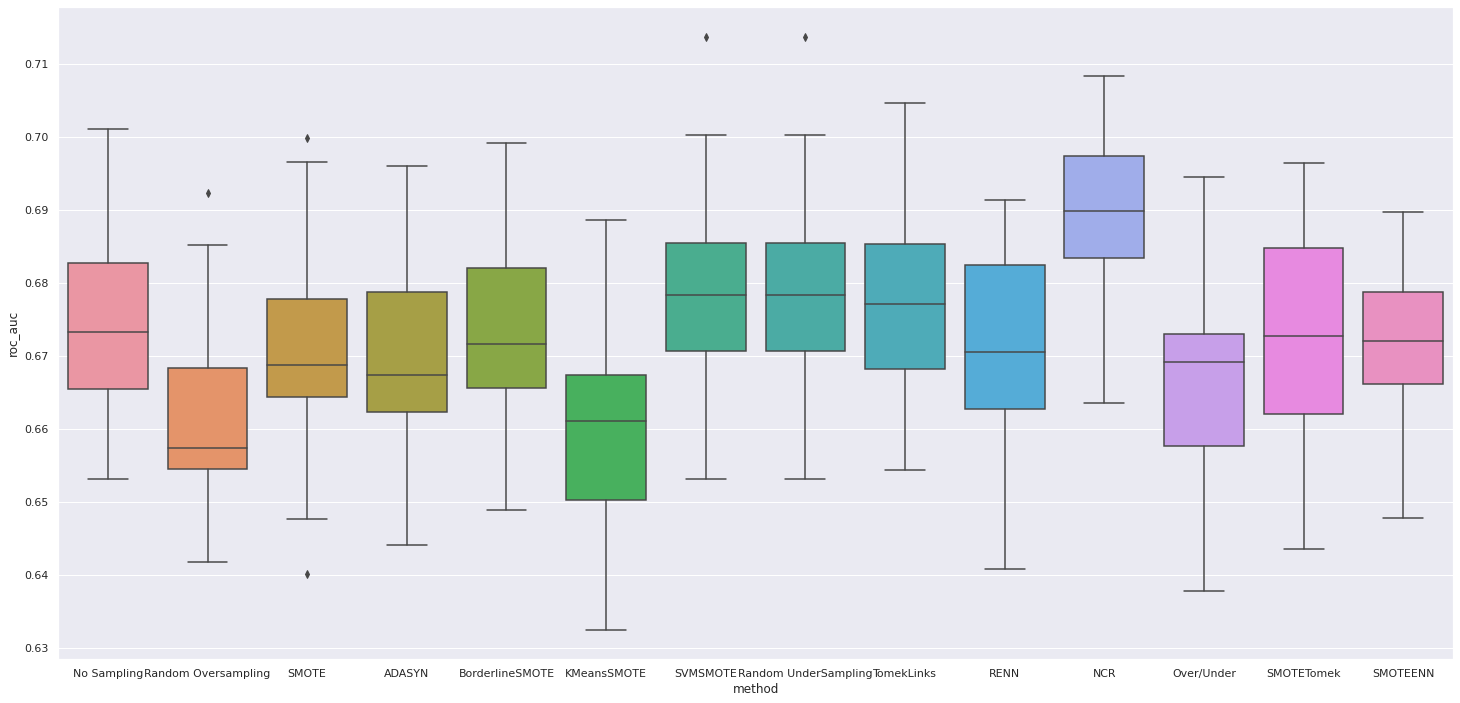

In [ ]:
# removing nearmiss which did not perfmorm well
res = pd.concat( [r1, r2, r3, r4, r5, r6, r7, r8, r10, r11, r12, r13, r14,r15], axis = 0 )
sns.boxplot(data = res, y = 'roc_auc', x = 'method' );


Most of the oversampling and undersampling methods did not perform any better than adopting no sampling procedure.

The only exception is Neighbourhood Cleaning Rule (NCR) So we can try to use it.

## 7.2 Models Comparison

### Logistic Regression


In [6]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
lr = LogisticRegression()
pipe = imbPipeline( steps =[ ('ncr', ncr), ('Logit', lr) ] )
r1 = eval_model_cv(pipe, X_train_t, y_train, 'lr', 5, 2)


Method: lr                        ROC_AUC: 0.7585911240381004


### SVM (sklearn.svm.SVC)


In [7]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
svc = SVC(kernel='linear')
pipe = imbPipeline( steps =[ ('ncr', ncr), ('SVM', svc) ] )
r2 = eval_model_cv(pipe, X_train_t, y_train, 'SVM', 5, 2)


Method: SVM                       ROC_AUC: 0.7610405370265143


### Random Forest


In [8]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
rfc = RandomForestClassifier()
pipe = imbPipeline( steps =[ ('ncr', ncr), ('RFC', rfc) ] )
r3 = eval_model_cv(pipe, X_train_t, y_train, 'RFC', 5, 2)


Method: RFC                       ROC_AUC: 0.785837924126706


### Balanced RF


In [9]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
brfc = BalancedRandomForestClassifier()
pipe = imbPipeline( steps =[ ('ncr', ncr), ('BRFC', brfc) ] )
r4 = eval_model_cv(pipe, X_train_t, y_train, 'BRFC', 5, 2)


Method: BRFC                      ROC_AUC: 0.7899677119550037


### XGBClassifier


In [12]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
xgb = XGBRFClassifier(use_label_encoder = False, eval_metric = 'auc')
pipe = imbPipeline( steps =[ ('ncr', ncr), ('xgb', xgb) ] )
r5 = eval_model_cv(pipe, X_train_t, y_train, 'XGB', 5, 2)

Method: XGB                       ROC_AUC: 0.792956944457821


### Catboost

In [13]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
cat = CatBoostClassifier(verbose = False)
pipe = imbPipeline( steps =[ ('ncr', ncr), ('cat', cat) ] )
r6 = eval_model_cv(pipe, X_train_t, y_train, 'CAT', 5, 2)

Method: CAT                       ROC_AUC: 0.796408346254972


### LightGBM

In [14]:
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
lgbm = LGBMClassifier()
pipe = imbPipeline( steps =[ ('ncr', ncr), ('lgbm', lgbm) ] )
r7 = eval_model_cv(pipe, X_train_t, y_train, 'LGBM', 5, 2)


Method: LGBM                      ROC_AUC: 0.7877500457474165


## 7.3 Comparing Performances of all Models

In [15]:
#list of all models
models = [lr, svc, rfc, brfc, xgb, cat, lgbm]

# scoring metrics that will be evaluated
scoring = {'roc_auc': 'roc_auc',
           'recall': 'recall',
           'precision': 'precision',
           'accuracy': 'accuracy'}

results = eval_models(models, scoring, 5, 2)

In [20]:
print('Best results in terms of roc_auc')
print(results.sort_values(['roc_auc'], ascending = False))

print('\nBest results in terms of recall')
print(results.sort_values(['recall'], ascending = False))

Best results in terms of roc_auc
                            Model   roc_auc    recall  precision  accuracy
0              CatBoostClassifier  0.796408  0.589264   0.495066  0.793687
0                 XGBRFClassifier  0.792957  0.549387   0.505210  0.797625
0  BalancedRandomForestClassifier  0.788463  0.733129   0.382574  0.704187
0                  LGBMClassifier  0.787750  0.589264   0.475864  0.783813
0          RandomForestClassifier  0.787034  0.573926   0.486675  0.789562
0                             SVC  0.761041  0.461350   0.475455  0.786500
0              LogisticRegression  0.758591  0.475153   0.465466  0.781813

Best results in terms of recall
                            Model   roc_auc    recall  precision  accuracy
0  BalancedRandomForestClassifier  0.788463  0.733129   0.382574  0.704187
0                  LGBMClassifier  0.787750  0.589264   0.475864  0.783813
0              CatBoostClassifier  0.796408  0.589264   0.495066  0.793687
0          RandomForestClassifier 

The best models in terms of **auc-roc** are: **CatBoost** and **XGBoost RF Classifier**.

In terms of **recall** (which is the most important metric in this problem) the best models are **LightGBM** and **Catboost**. 

The Balanced RF seems to be biased given the difference in recall and precision.

## 7.4 Comparing Selected Models

In [16]:
# Defining sampling and models
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')
cat = CatBoostClassifier(verbose = False)
lgbm = LGBMClassifier()

# defining train and validation sets
X_train_reduced, X_valid, y_train_reduced, y_valid = train_test_split( X_train_t, y_train, test_size = 0.2, random_state = 42 )

# verifying proportions
print( 'Proportion of 1s in train data: {:,.2f}'.format( Counter(y_train_reduced)[1]/Counter(y_train_reduced)[0] ) )
print( 'Proportion of 1s in test  data: {:,.2f}'.format( Counter(y_valid)[1]/Counter(y_valid)[0] ) )

# evaluating catboost model
pipe = imbPipeline( steps =[ ('ncr', ncr), ('cat', cat) ] )
y_score = pipe.fit(X_train_reduced, y_train_reduced).predict_proba(X_valid)

pipe2 = imbPipeline( steps =[ ('ncr', ncr), ('lgbm', lgbm) ] )
y_score2 = pipe2.fit(X_train_reduced, y_train_reduced).predict_proba(X_valid)


Proportion of 1s in train data: 0.26
Proportion of 1s in test  data: 0.24


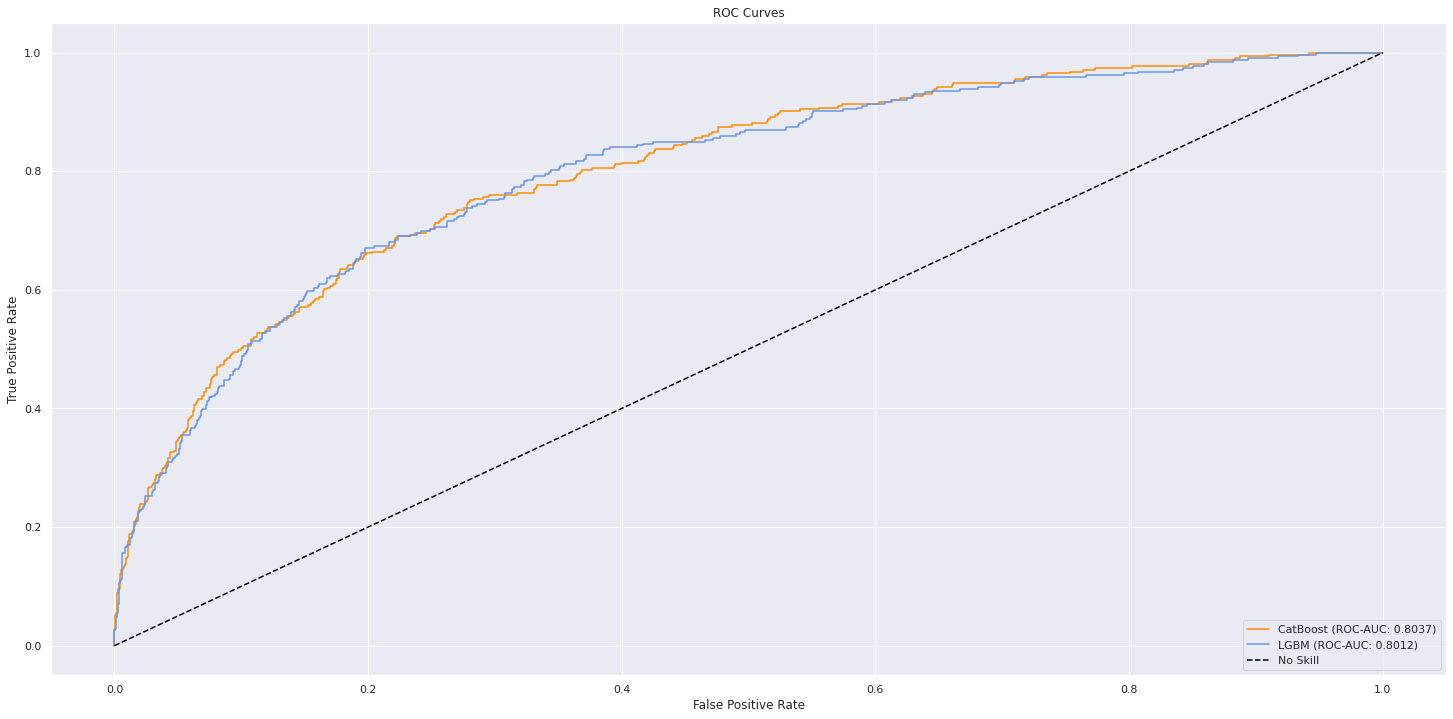

In [17]:
fig, ax = plt.subplots()
tpr, fpr, _ = roc_curve(y_valid, y_score[:,1], pos_label=1)
ax.plot(tpr, fpr, color='darkorange', label = 'CatBoost (ROC-AUC: {:.4f})'.format(roc_auc_score(y_valid, y_score[:,1]) ) )

tpr, fpr, _ = roc_curve(y_valid, y_score2[:,1], pos_label = 1)

ax.plot(tpr, fpr, color='cornflowerblue', label = 'LGBM (ROC-AUC: %0.4f)' % roc_auc_score(y_valid, y_score2[:,1]) )
ax.plot([0,1], [0,1], linestyle = '--', color = 'black', label= 'No Skill')
ax.set_title('ROC Curves')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc = 'lower right');

Both models appear to have virtually the same level of ability predicting churn. The differences between curves are probably not signifcant.

Also, we see that classes churn and no churn are not easily separable, otherwise the curves of both models would be rising steeper in the first region of the graph (more towards a ideal classifier)

Since we have an inbalance between classes, we should also take a look at the precision recall curve.

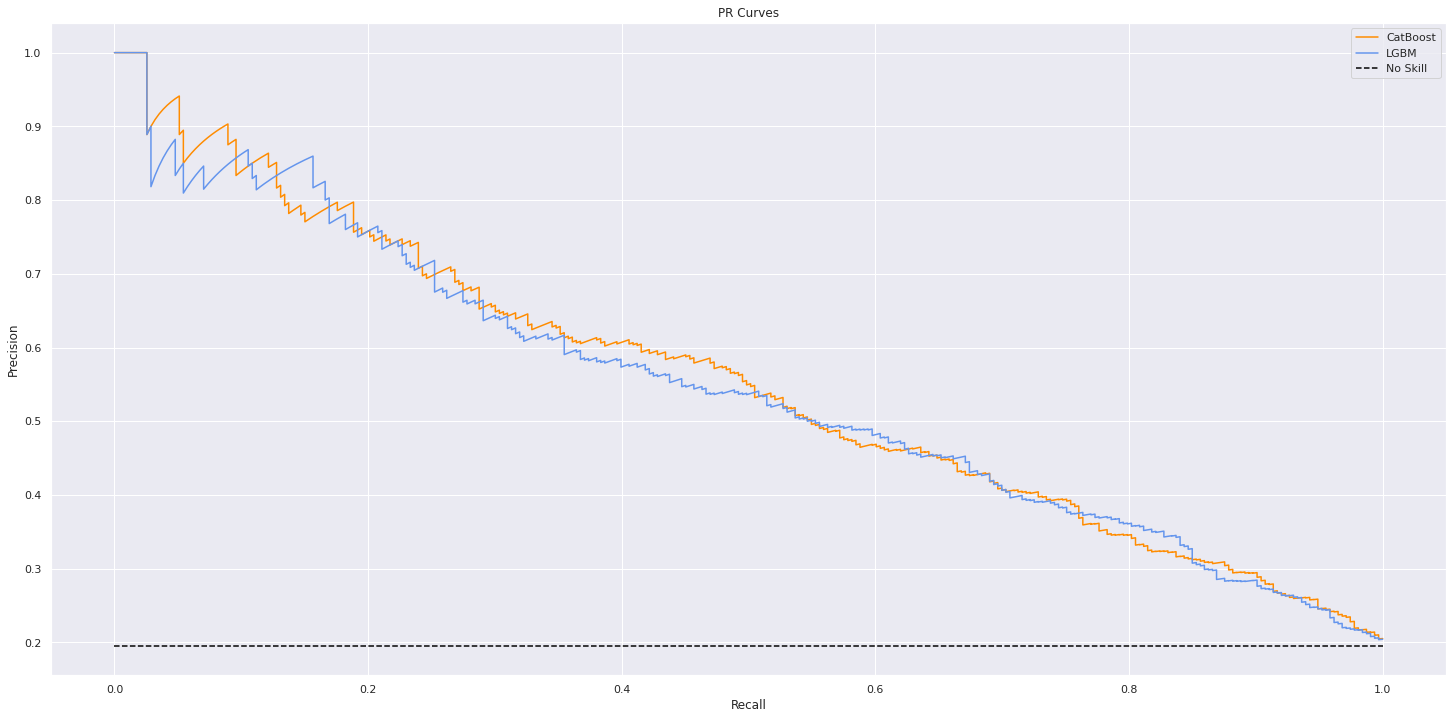

In [18]:
fig, ax = plt.subplots()

#Catboost
pr, rc, _ = precision_recall_curve(y_valid, y_score[:, 1] )
ax.plot( rc, pr, label = 'CatBoost', color = 'darkorange')

# LGBM
pr, rc, _ = precision_recall_curve(y_valid, y_score2[:, 1] )
ax.plot( rc, pr, label = 'LGBM', color = 'cornflowerblue')

#No skill classifier
no_skill = len( y_valid[y_valid==1] )/len(y_valid) #amount of 1s / total observations
ax.plot([0, 1], [no_skill, no_skill], linestyle = '--', color = 'black', label= 'No Skill')

ax.set_title('PR Curves')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc = 'best');


Both models have very similar performances so choosing between them will come down to simplicity of use and resources consumption.

Let's verify wheter balancing classes to a 50% 50% percentage will increase learning ability

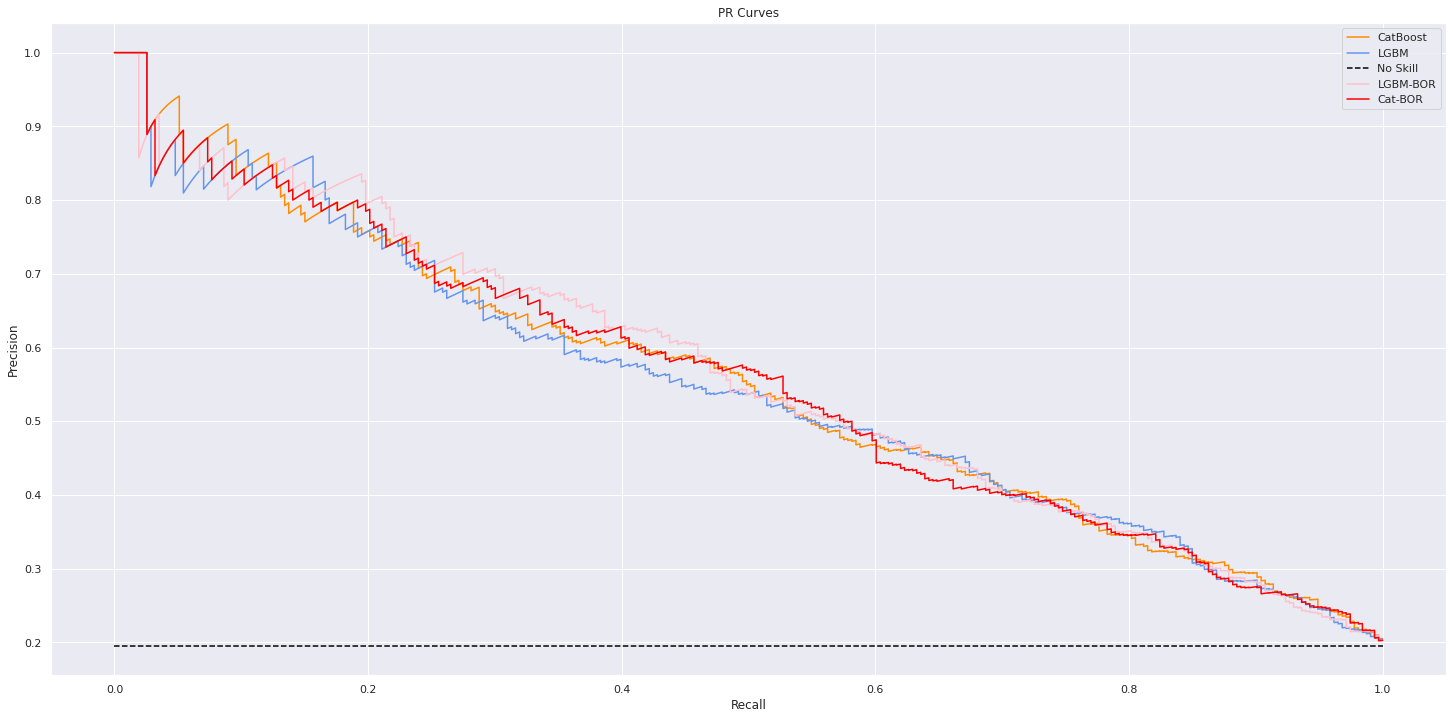

In [21]:
fig, ax = plt.subplots()

#Catboost
pr, rc, _ = precision_recall_curve(y_valid, y_score[:, 1] )
ax.plot( rc, pr, label = 'CatBoost', color = 'darkorange')

# LGBM
pr, rc, _ = precision_recall_curve(y_valid, y_score2[:, 1] )
ax.plot( rc, pr, label = 'LGBM', color = 'cornflowerblue')

#No skill classifier
no_skill = len( y_valid[y_valid==1] )/len(y_valid) #amount of 1s / total observations
ax.plot([0, 1], [no_skill, no_skill], linestyle = '--', color = 'black', label= 'No Skill')

## Adding a 

# Borderline LGBM
bor = BorderlineSMOTE(sampling_strategy=1.0)
pipe3 = imbPipeline( steps =[ ('ncr', ncr), ('bor', bor), ('lgbm', lgbm) ] )
y_score3 = pipe3.fit(X_train_reduced, y_train_reduced).predict_proba(X_valid)

pr, rc, _ = precision_recall_curve(y_valid, y_score3[:, 1] )
ax.plot( rc, pr, label = 'LGBM-BOR', color = 'pink')

# Borderline CatBoost
bor = BorderlineSMOTE(sampling_strategy=1.0)
pipe3 = imbPipeline( steps =[ ('ncr', ncr), ('bor', bor), ('lgbm', cat) ] )
y_score3 = pipe3.fit(X_train_reduced, y_train_reduced).predict_proba(X_valid)

pr, rc, _ = precision_recall_curve(y_valid, y_score3[:, 1] )
ax.plot( rc, pr, label = 'Cat-BOR', color = 'red')

ax.set_title('PR Curves')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.legend(loc = 'best');


No gain in performance has been obtained. At least we see that both models work well with imbalanced classes

Now let's evaluate the Kolmogorov-Smirnov Statistic to see at which threshold of predicted proba the maximum separation between classes occurs.

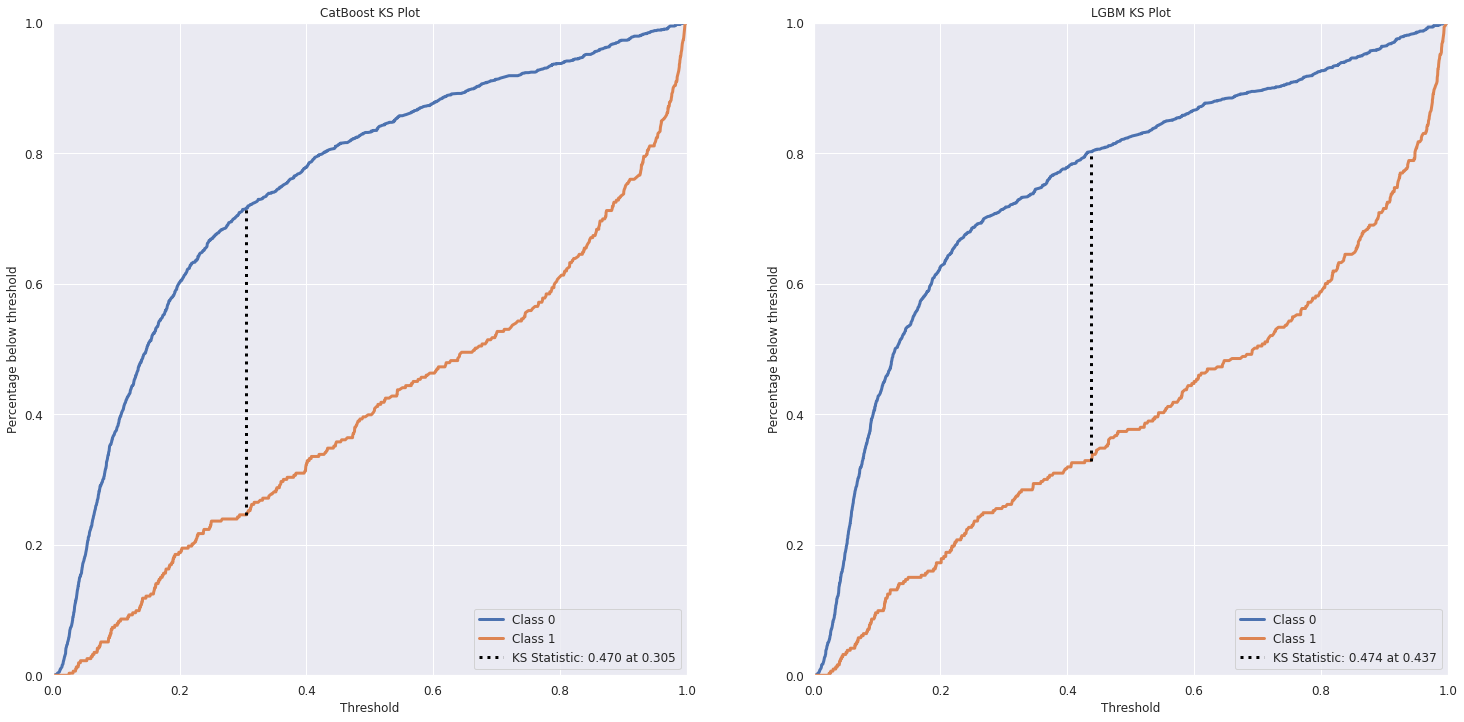

In [172]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plot_ks_statistic(y_valid, y_score, ax = ax1)
ax1.set_title('CatBoost KS Plot')

plot_ks_statistic(y_valid, y_score2, ax = ax2)
ax2.set_title('LGBM KS Plot');

If we desire optimal feature separation we could use this threshold. Nonetheless, it is better to evaluate the financial return for each threshold and then select a satisfactory value for it

Finally, checking feature importance for each model.

In [52]:
# Verifying features' importances for each model
# Column names after preprocessing
columns_names = ['cat__gender_Female','cat__gender_Male','cat__geography_France','cat__geography_Germany','cat__geography_Spain','num__credit_score','num__age','num__tenure','num__balance','num__salary','remainder__has_cr_card','remainder__active_member']

# Fitting most promissing models
lgbm.fit(X_train_t, y_train)
cat.fit(X_train_t, y_train)

# Evaluating Feature Importance for them
lgbm_features = pd.DataFrame(list(zip(columns_names,lgbm.feature_importances_)), columns=['Feature', 'Importance'] )
lgbm_features.sort_values(['Importance'], ascending = False, inplace=True)

catboost_features = pd.DataFrame( list(zip(columns_names, cat.feature_importances_)), columns=['Feature', 'Importance'] )
catboost_features.sort_values(['Importance'], ascending = False, inplace=True)

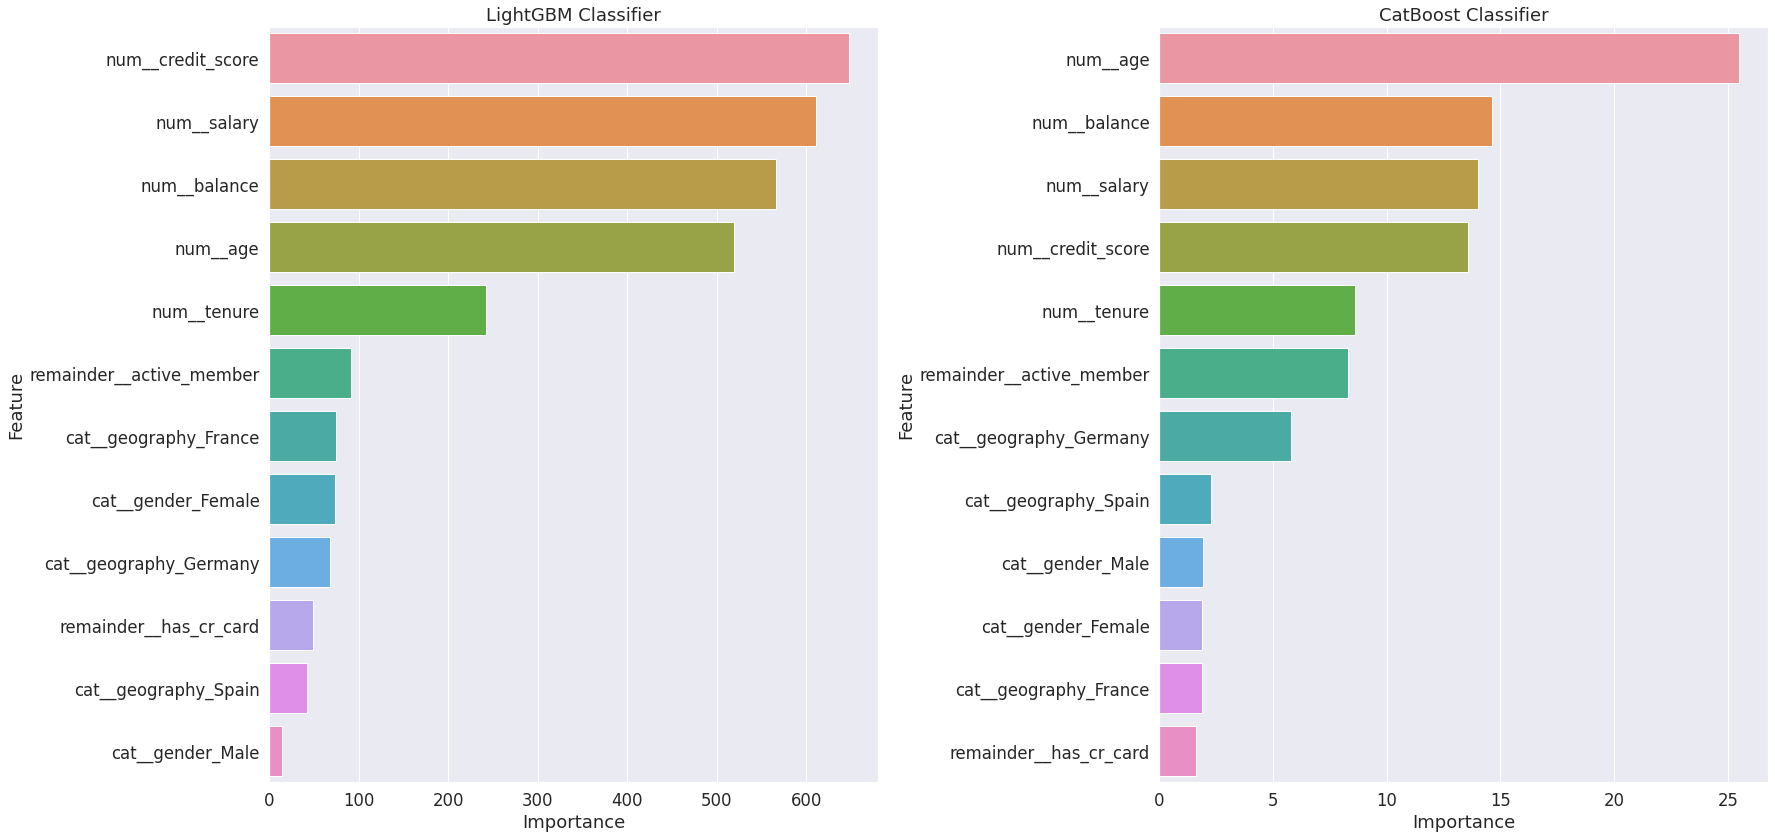

In [65]:
sns.set(font_scale=1.5)
plt.subplot(1,2,1)
sns.barplot(data = lgbm_features, x = 'Importance', y = 'Feature');
plt.title('LightGBM Classifier')

plt.subplot(1,2,2)
sns.barplot(data = catboost_features, x = 'Importance', y = 'Feature');
plt.title('CatBoost Classifier');
plt.tight_layout()

Among the top 5 most important features CatBoost seems to give much more importance to customer age than other features, while LightGBM is more balanced throughout features.

Given that both models show very similar performances, we'll use LightGBM since it is faster to compute and shows better feature importance balance. However if necessary we could use CatBoost in a next cycle

# 8. Hyperparameter Fine Tunning

In [3]:
# Reading data

interim_path = '../data/interim/'
X_train_t = pickle.load( open(interim_path + 'X_train_t.pkl', 'rb'))
X_test_t = pickle.load( open(interim_path + 'X_test_t.pkl', 'rb'))
y_train = pickle.load( open(interim_path + 'y_train.pkl', 'rb'))
y_test = pickle.load( open(interim_path + 'y_test.pkl', 'rb'))

print( 'Proportion of 1s in train data: {:,.2f}'.format( Counter(y_train)[1]/Counter(y_train)[0] ) )
print( 'Proportion of 1s in test  data: {:,.2f}'.format( Counter(y_test)[1]/Counter(y_test)[0] ) )


Proportion of 1s in train data: 0.26
Proportion of 1s in test  data: 0.26


In [18]:
search_space = [ Integer(1, 15, name = 'max_depth'),
                 Integer(10, 1000, name = 'n_estimators'), 
                 Real(0.1, 10, name = 'learning_rate'),
                 Real(0.001, 1, name = 'min_child_weight') ]

#objective 'binary'

model = LGBMClassifier(objective='binary', n_jobs=-1)
scoring = 'roc_auc'
n_splits = 5 
n_repeats = 2
verbose = 0

@use_named_args(search_space)
def cost_f(**params):    
    
    #define cross validation
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats= n_repeats, random_state = 42)
    
    #define sampling procedure
    ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')

    model.set_params(**params)
    #define pipeline
    pipe = imbPipeline( steps =[ ('ncr', ncr), ('model', model) ] )

    # calculate scores for crossvalidated pipeline
    scores = cross_val_score( pipe, X_train_t, y_train, scoring= scoring, cv = cv, n_jobs= -1, verbose= verbose )
            
    return np.mean(scores)*(-1)

res = gp_minimize(cost_f, search_space, n_calls = 100, n_initial_points= 10)
dump(res, '../reports/result')

In [41]:
print( 'Best ROC-AUC obtained: {:,.6f}'.format(-res.fun) )
print( 'Best Parameters: \nmax_depth = {} \nn_estimators = {} \nlearning_rate= {:,.6f} \nmin_child_weight = {:,.6f}'.format(res.x[0], res.x[1], res.x[2], res.x[3] ) )


Best ROC-AUC obtained: 0.797580
Best Parameters: 
max_depth = 3 
n_estimators = 51 
learning_rate= 0.326700 
min_child_weight = 0.800737


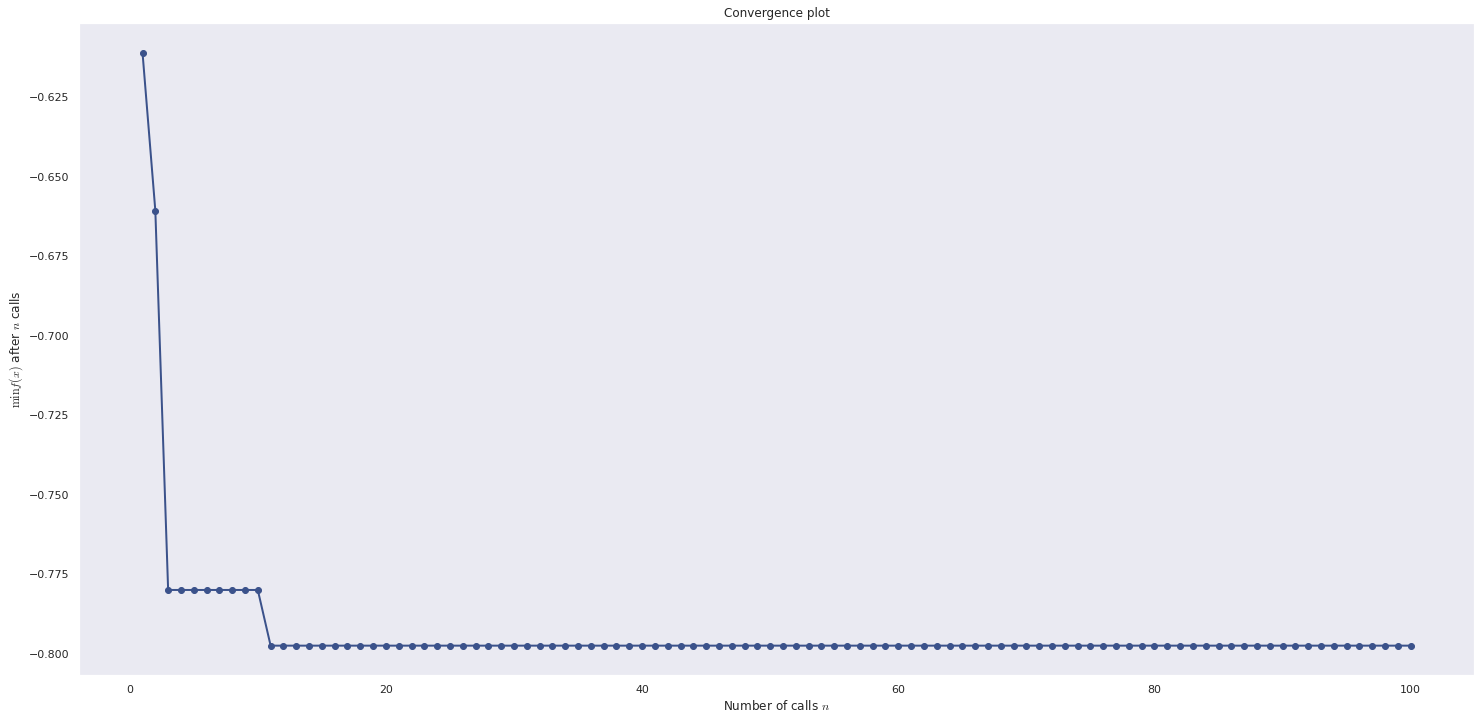

In [20]:
# Convergence curve for the iterations
plot_convergence(res);

# 9. Convert Model Performance to Business Values

## 9.1 Machine Learning Performance

In [47]:
model = LGBMClassifier(objective='binary', n_jobs=-1)
ncr = NeighbourhoodCleaningRule(sampling_strategy='majority')

params = {'max_depth': 3,
          'n_estimators': 51 , 
          'learning_rate': 0.3267,
          'min_child_weight': 0.8007 }

# setting model parameters
model.set_params(**params)
pipe = imbPipeline( steps =[ ('ncr', ncr), ('model', model) ] )

pipe.fit(X_train_t,y_train)
y_hat = pipe.predict(X_test_t)

print( ' ROC AUC = %.4f' %(roc_auc_score(y_test, y_hat)) )
print(classification_report(y_test, y_hat))

 ROC AUC = 0.7151
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1593
           1       0.49      0.59      0.53       407

    accuracy                           0.79      2000
   macro avg       0.69      0.72      0.70      2000
weighted avg       0.81      0.79      0.80      2000



In [69]:
from scikitplot.metrics import plot_precision_recall, plot_lift_curve, plot_roc, plot_cumulative_gain

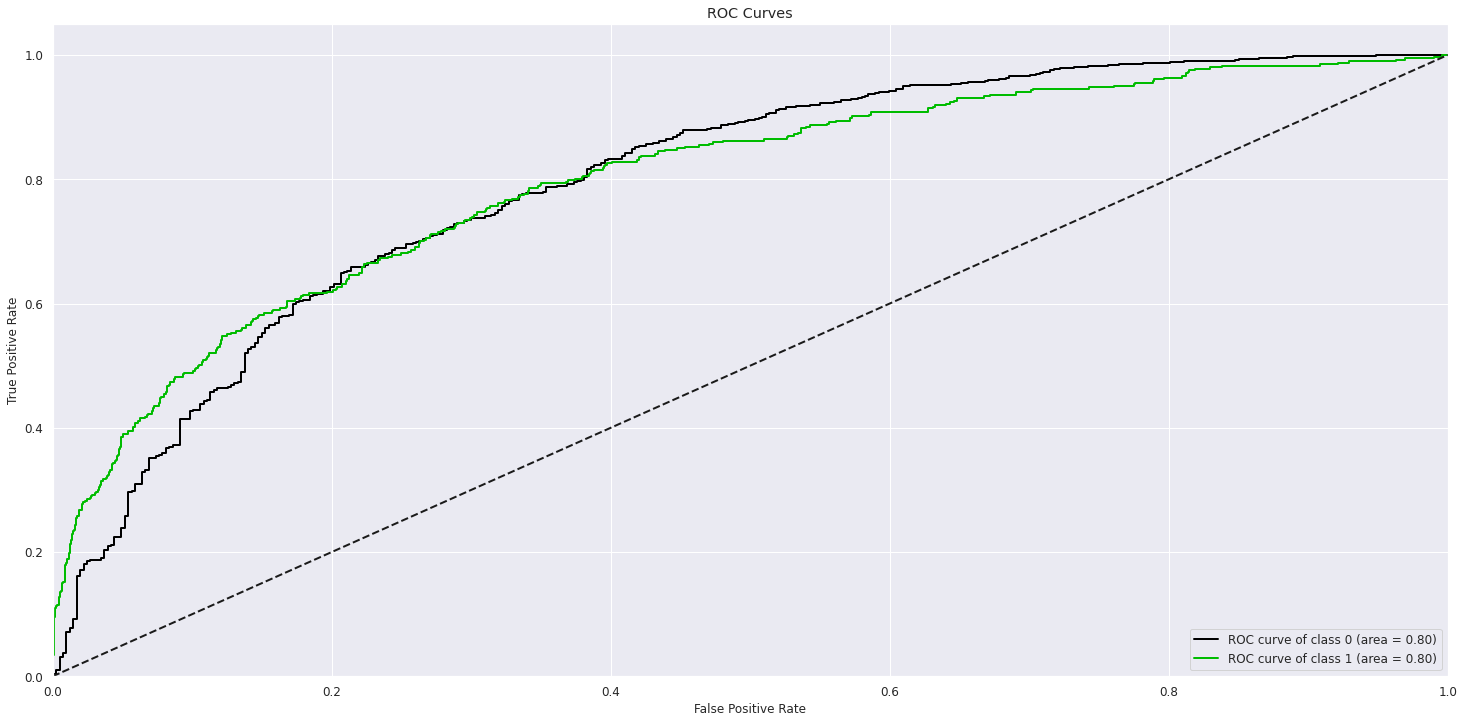

In [58]:
plot_roc(y_test, y_score, plot_micro = False, plot_macro = False);

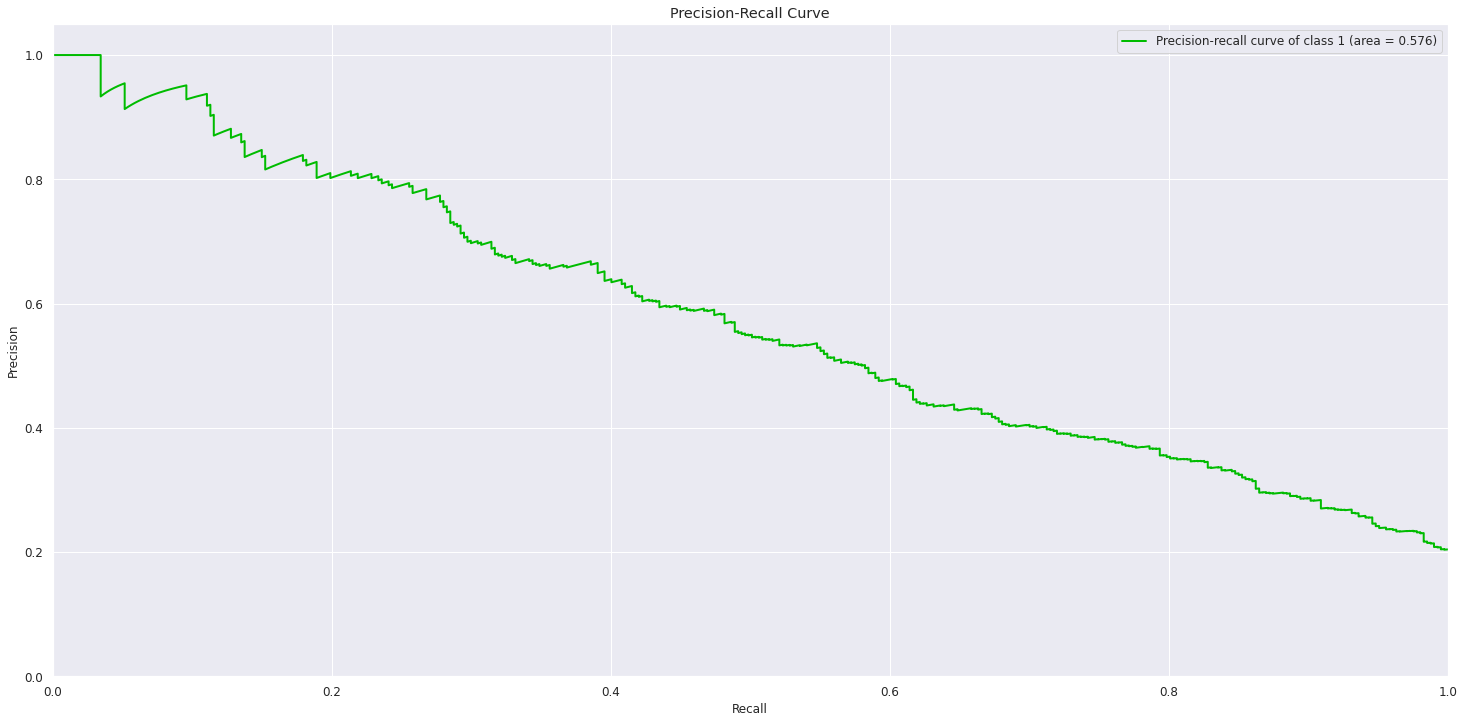

In [65]:
plot_precision_recall(y_test, y_score, plot_micro = False, classes_to_plot = 1);


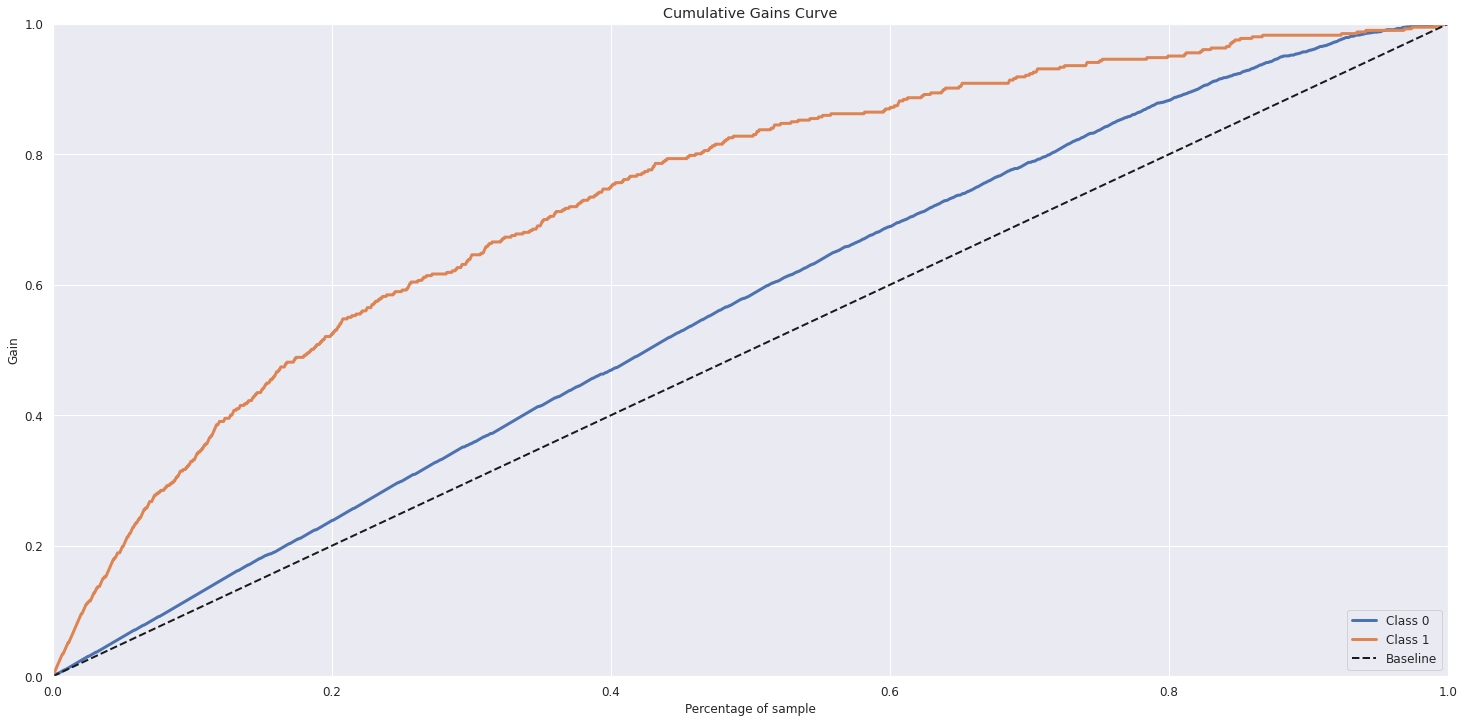

In [71]:
plot_cumulative_gain(y_test, y_score);

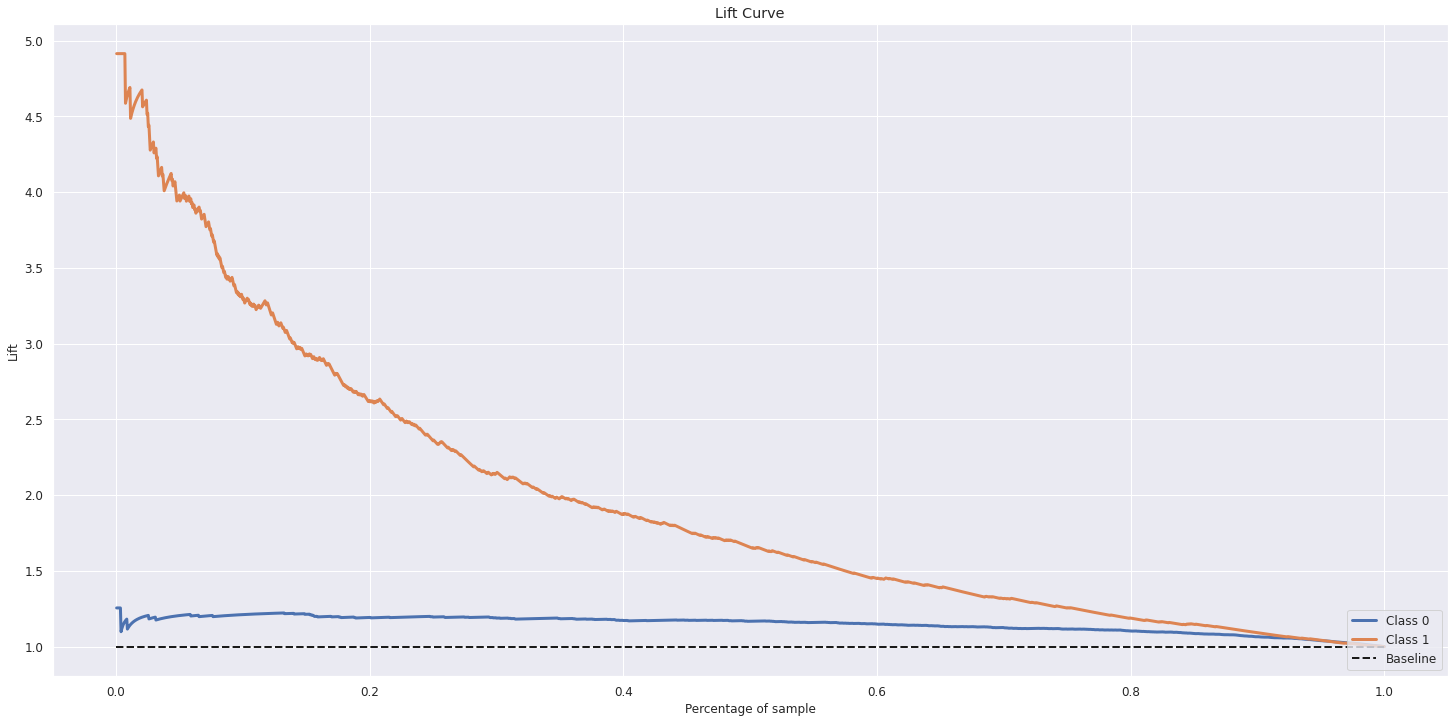

In [68]:
plot_lift_curve(y_test, y_score );

## 9.2 Financial Performance

The action plan suggested to avoid churn in this case is giving cupouns acording to the predicted churn probability:

- p(churn) > 95 -> $500 coupon
- p(churn) between 90 & 95 -> $250 coupon
- p(churn) between 80 & 90 -> $200 coupon
- p(churn) between 70 & 80 -> $100 coupon

In [ ]:
# Reading data

interim_path = '../data/interim/'
X_train_t = pickle.load( open(interim_path + 'X_train_t.pkl', 'rb'))
X_test_t = pickle.load( open(interim_path + 'X_test_t.pkl', 'rb'))
y_train = pickle.load( open(interim_path + 'y_train.pkl', 'rb'))
y_test = pickle.load( open(interim_path + 'y_test.pkl', 'rb'))

print( 'Proportion of 1s in train data: {:,.2f}'.format( Counter(y_train)[1]/Counter(y_train)[0] ) )
print( 'Proportion of 1s in test  data: {:,.2f}'.format( Counter(y_test)[1]/Counter(y_test)[0] ) )


Proportion of 1s in train data: 0.26
Proportion of 1s in test  data: 0.26


In [106]:
df5 = pd.read_csv( '../data/interim/df1.csv' )
df5 = df5.drop(columns = [ 'row_number', 'customer_id', 'surname', 'num_of_products' ], axis = 1)

X = df5.iloc[:, :-1].copy()
y = df5.iloc[:, -1].copy()

# spliting train and test datasets
X_train, X_test, y_train, y_test = train_test_split( X, y, 
                                                     test_size = 0.2, 
                                                     random_state = 42, 
                                                     shuffle = True, 
                                                     stratify = y ) # stratify train and test datasets based on response variable

# # selecting columns to be transformed
# cat_columns = ['gender', 'geography']
# num_columns = ['credit_score', 'age', 'tenure', 'balance', 'salary']

# # Strategy selected to each column
# # 'credit_score', 'age', 'tenure', 'balance', 'salary'  | minmax
# # 'has_cr_card', 'active_member'              | nothing

# # Defining transformers
# ohe = OneHotEncoder()
# min_max = MinMaxScaler()
# preprocessor = ColumnTransformer(
#     transformers= [ ('cat', ohe, cat_columns),
#                     ('num', min_max, num_columns) ], remainder= 'passthrough' ) 


# preprocessing_pipe = Pipeline( steps = [ ('preprocessor', preprocessor) ] )
# X_train_t = preprocessing_pipe.fit_transform( X_train )
# X_test_t = preprocessing_pipe.transform( X_test )

# X_train = preprocessing_pipe.inverse_transform(X_train_t)

# columns_names = ['cat__gender_Female','cat__gender_Male','cat__geography_France','cat__geography_Germany','cat__geography_Spain','num__credit_score','num__age','num__tenure','num__balance','num__salary','remainder__has_cr_card','remainder__active_member']
# X_train = pd.DataFrame(X_train_t, columns = columns_names)

# X_train['ltv'] = X_train.apply( lambda x: x['num__balance']*0.08 + x['num__salary']*0.05, axis = 1 )
# X_train['ltv'].head()

# defining percentage of balance and salary that makes up LTV (life time value) for each customer in test dataset

per_balance = 0.08 
per_salary = 0.05

X_test = pd.concat( [X_test, y_test], axis = 1 )

X_test['ltv'] = X_test.apply( lambda x: x['balance']*per_balance + x['salary']*per_salary, axis = 1 )
X_test['churn_proba'] = y_score[:,1]
X_test.head()

,credit_score,geography,gender,age,tenure,balance,has_cr_card,active_member,salary,exited,ltv,churn_proba
5702,585,France,Male,36,7,0.00,1,0,94283.09,0,4714.1545,0.092522
3667,525,Germany,Male,33,4,131023.76,0,0,55072.93,0,13235.5473,0.356277
1617,557,Spain,Female,40,4,0.00,0,1,105433.53,0,5271.6765,0.320571
5673,639,Spain,Male,34,5,139393.19,0,0,33950.08,0,12848.9592,0.119027
4272,640,Spain,Female,34,3,77826.80,1,1,168544.85,0,14653.3865,0.146088


In [132]:
rev_lost = X_test[X_test['exited'] == 1][['ltv']].sum()[0]
print('Total Revenue lost due to churn (test dataset) ${:,.2f}'.format(rev_lost) )

Total Revenue lost due to churn (test dataset) $4,955,747.17


In [107]:
X_test.sort_values(['churn_proba'], ascending = False)

,credit_score,geography,gender,age,tenure,balance,has_cr_card,active_member,salary,exited,ltv,churn_proba
2168,705,Germany,Female,56,2,143249.67,1,0,88428.41,1,15881.3941,0.997890
3885,642,Germany,Female,56,6,103244.86,1,0,143049.72,1,15412.0748,0.997386
2350,617,Germany,Female,58,3,119024.75,1,0,35199.24,1,11281.9420,0.996608
776,622,Germany,Female,58,7,116922.25,1,0,120415.61,1,15374.5605,0.996202
2473,351,Germany,Female,57,4,163146.46,1,0,169621.69,1,21532.8013,0.995855
3991,496,Germany,Female,59,7,91680.10,1,0,163141.18,1,15491.4670,0.995345
5942,517,Germany,Male,53,0,109172.88,1,0,54676.10,1,11467.6354,0.995067
4732,638,Germany,Female,53,1,123916.67,1,0,16657.68,1,10746.2176,0.994278
4153,695,Germany,Female,53,8,95231.91,0,0,70140.80,1,11125.5928,0.992511
7008,635,Germany,Female,65,5,117325.54,1,0,155799.86,1,17176.0362,0.992119


# 10. Deploy Modelo to Production